#Zesty.Ai Case Study

In this analysis, we will take a look at the data found at https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdata  

The main goal of the analysis is to try to predict the energy consumption.  

## Feature Engineering

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid") # Set a default seaborn style
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Load the data 
data = pd.read_csv("recs2009_public.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (717,718) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Do we have any missing data? 
data.describe().transpose()[data.describe().transpose()["count"] != 12083]
# No, there is no missing data so this means we don't need to remove any columns due to missingness
# It also means we don't need to impute any values 


,count,mean,std,min,25%,50%,75%,max


It looks like there is a flag column that indicates whether or not a different column was imputed. We will keep the reows even if they were imputed but the actual flag is to no use of us, so we will remove those columns. It seems like if the column name starts with a 'z' then it is the flag column.  

**Note: All the assumptions for the data columns are based on the codebook (excel file).**

In [4]:
# Get all the column names 
col_names = data.columns

# Which ones start with a z?
to_remove = col_names.str.startswith("Z")


In [5]:
data = data.drop(col_names[to_remove], axis = 1) # Remove those columns

In [6]:
data # Updated dataset
# It looks like we have 581 columns remaining

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,12079,2,3,9,2,10219.80,7671,332,7784,451,...,-2,6A-6B,4289,39,7819,0.59,0,48,-3,84
12079,12080,3,7,21,4,8689.07,2085,2844,2520,2286,...,-2,3B-4B,360,393,1869,0.50,0,56,26,101
12080,12081,2,4,10,2,4697.21,7935,472,8074,600,...,-2,6A-6B,4494,22,8477,0.58,1,46,-9,89
12081,12082,4,8,23,2,13155.68,5834,770,5989,957,...,-2,5B-5C,2840,0,9010,0.54,1,53,13,93


In [7]:
# There are columns that we want to exclude since these will be directly correlated to the overall KWH 
# KWHSPH, KWHCOL, KWHWTH, KWHRFG, KWHOTH are the KWH broken down (KWH is the total of those)
# BTUEL, BTUELSPH, BTUELELCOL, BTUELWTH, BTUELRFG, BTUELOTH is just a different unit of KWH
# DOLLAREL, DOLELSPH, DOLELCOL, DOLELWTH, DOLELRFG, DOLELOTH is how much they are spendong on electricity. 
# This may introduce look-ahead bias since we don't know how much they spend on electricity before the use it, so it should not be included

data = data.drop("KWHSPH KWHCOL KWHWTH KWHRFG KWHOTH BTUEL BTUELSPH BTUELCOL \
  BTUELWTH BTUELRFG BTUELOTH DOLLAREL DOLELSPH DOLELCOL DOLELWTH DOLELRFG \
  DOLELOTH".split(), axis = 1) # Updated dataset

data # 564 columns now (581 before and we removed 17)


,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,12079,2,3,9,2,10219.80,7671,332,7784,451,...,-2,6A-6B,4289,39,7819,0.59,0,48,-3,84
12079,12080,3,7,21,4,8689.07,2085,2844,2520,2286,...,-2,3B-4B,360,393,1869,0.50,0,56,26,101
12080,12081,2,4,10,2,4697.21,7935,472,8074,600,...,-2,6A-6B,4494,22,8477,0.58,1,46,-9,89
12081,12082,4,8,23,2,13155.68,5834,770,5989,957,...,-2,5B-5C,2840,0,9010,0.54,1,53,13,93


In [8]:
# Since KWH, BTU and $ are practically measuring the same thing, we expect there to be really high correlation among them
# This will lead to our models having high multicolinearity so we probably want to remove these

# Remove columns that start with BTU and DOL
# Get all the column names 
col_names = data.columns

# Which ones start with either BTU (these are the ones that represent the different units of energy) & DOL (the dollar amounts)
# And TOTAL since these are total amounts (again in dollars)
to_remove = col_names.str.startswith(('BTU', 'DOL', 'TOTAL'))

# Remove these 
data = data.drop(col_names[to_remove], axis = 1) # Remove those columns

In [9]:
data # We have 519 columns remaining

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,12079,2,3,9,2,10219.80,7671,332,7784,451,...,-2,6A-6B,4289,39,7819,0.59,0,48,-3,84
12079,12080,3,7,21,4,8689.07,2085,2844,2520,2286,...,-2,3B-4B,360,393,1869,0.50,0,56,26,101
12080,12081,2,4,10,2,4697.21,7935,472,8074,600,...,-2,6A-6B,4494,22,8477,0.58,1,46,-9,89
12081,12082,4,8,23,2,13155.68,5834,770,5989,957,...,-2,5B-5C,2840,0,9010,0.54,1,53,13,93


It seems like most of our data is actually categorical. Even though it may seem continuous, most of the values are actually labels. This means they are factors and not continuous variables. 
This means that we can't use them as they are in our model - we will need to preform one hot encoding. Before that, however, we need to reduce the number of columns as we have too many.

In [10]:
# Since we already have an index in the pandas df, we don't need the first column since that is another index column
data = data.drop('DOEID', axis = 1) 

In [11]:
data # 530 columns remaining

,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,Climate_Region_Pub,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,2,4,12,2,2471.68,4742,1080,4953,1271,4,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,4,10,26,2,8599.17,2662,199,2688,143,5,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,1,1,1,5,8969.92,6233,505,5741,829,1,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,2,3,7,2,18003.64,6034,672,5781,868,1,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,1,1,1,3,5999.61,5388,702,5313,797,1,...,-2,5A,2251,0,5426,0.61,4,50,13,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,2,3,9,2,10219.80,7671,332,7784,451,1,...,-2,6A-6B,4289,39,7819,0.59,0,48,-3,84
12079,3,7,21,4,8689.07,2085,2844,2520,2286,2,...,-2,3B-4B,360,393,1869,0.50,0,56,26,101
12080,2,4,10,2,4697.21,7935,472,8074,600,1,...,-2,6A-6B,4494,22,8477,0.58,1,46,-9,89
12081,4,8,23,2,13155.68,5834,770,5989,957,1,...,-2,5B-5C,2840,0,9010,0.54,1,53,13,93


In [12]:
# What columns seem continuous? 
# NWEIGHT HDD65 CDD65 HDD30YR CDD30YR TOTSQFT TOTSQFT_EN TOTHSQFT TOTUSQFT TOTCSQFT TOTUSQFT HDD50 CDD80 GND_HDD65 WSF OA_LAT GWT DesignDBT99 DesignDBT1
# CUFEETNG CUFEETNGSPH CUFEETNHGOTH GALLONLPSPH GALLONLPWTH GALLONLPOTH GALLONFO GALLONFOSPH GALLONFOWTH GALLONFOOTH
# GALLONKER GALLONKERSPH GALLONKERWTH GALLONKEROTH TOTUCSQFT
con_cols = 'NWEIGHT HDD65 CDD65 HDD30YR CDD30YR TOTSQFT TOTSQFT_EN TOTHSQFT \
  TOTUSQFT TOTCSQFT TOTUSQFT HDD50 CDD80 GND_HDD65 WSF OA_LAT GWT DesignDBT99 \
  DesignDBT1 CUFEETNG CUFEETNGSPH CUFEETNGOTH GALLONLPSPH GALLONLPWTH \
  GALLONLPOTH GALLONFO GALLONFOSPH GALLONFOWTH GALLONFOOTH GALLONKER \
  GALLONKERSPH GALLONKERWTH GALLONKEROTH CUFEETNGWTH TOTUCSQFT'.split()
data[con_cols]

,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,TOTSQFT,TOTSQFT_EN,TOTHSQFT,TOTUSQFT,TOTCSQFT,...,GALLONFO,GALLONFOSPH,GALLONFOWTH,GALLONFOOTH,GALLONKER,GALLONKERSPH,GALLONKERWTH,GALLONKEROTH,CUFEETNGWTH,TOTUCSQFT
0,2471.68,4742,1080,4953,1271,5075,4675,3958,1118,3958,...,0,0.0,0.0,0.0,0,0,0,0,0.00,1118
1,8599.17,2662,199,2688,143,3136,2736,2736,400,2736,...,0,0.0,0.0,0.0,0,0,0,0,293.76,400
2,8969.92,6233,505,5741,829,528,528,528,0,264,...,0,0.0,0.0,0.0,0,0,0,0,77.39,264
3,18003.64,6034,672,5781,868,2023,1623,1623,400,1623,...,0,0.0,0.0,0.0,0,0,0,0,0.00,400
4,5999.61,5388,702,5313,797,1912,1912,1274,637,0,...,0,0.0,0.0,0.0,0,0,0,0,135.45,1912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,10219.80,7671,332,7784,451,2560,2160,893,1667,893,...,0,0.0,0.0,0.0,0,0,0,0,0.00,1667
12079,8689.07,2085,2844,2520,2286,502,502,502,0,502,...,0,0.0,0.0,0.0,0,0,0,0,35.56,0
12080,4697.21,7935,472,8074,600,4581,4181,4181,400,4181,...,0,0.0,0.0,0.0,0,0,0,0,237.96,400
12081,13155.68,5834,770,5989,957,1728,1728,864,864,518,...,0,0.0,0.0,0.0,0,0,0,0,121.13,1210


In [13]:
# Hmm it looks like some of the values are just 0, let's take a closer look at these
data['CUFEETNG CUFEETNGSPH CUFEETNGOTH GALLONLPSPH GALLONLPWTH GALLONLPOTH \
  GALLONFO GALLONFOSPH GALLONFOWTH GALLONFOOTH GALLONKER GALLONKERSPH \
  GALLONKERWTH GALLONKEROTH CUFEETNGWTH'.split()].describe()
  # It seems like some of them are almost all 0s, since they have quite a lot SD, that means they might not do a good job predicting KWH so we might want to remove those eventually

,CUFEETNG,CUFEETNGSPH,CUFEETNGOTH,GALLONLPSPH,GALLONLPWTH,GALLONLPOTH,GALLONFO,GALLONFOSPH,GALLONFOWTH,GALLONFOOTH,GALLONKER,GALLONKERSPH,GALLONKERWTH,GALLONKEROTH,CUFEETNGWTH
count,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000
mean,405.308781,249.091764,46.166555,28.244357,6.803283,6.036223,43.063809,37.233512,5.293509,0.536883,1.566664,1.328726,0.067698,0.170239,110.051123
std,476.226255,333.432818,108.060769,153.553941,46.863818,47.103249,175.944552,153.571687,33.732291,14.654809,21.470774,19.413278,4.609917,6.922723,148.966328
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,279.000000,41.310000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,57.100000
75%,683.000000,449.865000,59.655000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,189.015000
max,4501.000000,3296.040000,3767.000000,6008.000000,1069.000000,2256.650000,3078.000000,2407.220000,896.600000,777.000000,561.000000,550.000000,382.000000,425.000000,2772.000000


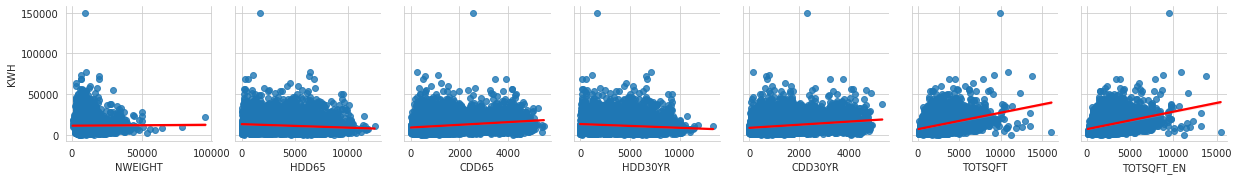

In [14]:
# Do these variables seem to be correlated with KWH? 
sns.pairplot(
    data,
    x_vars=con_cols[0:7],
    y_vars=['KWH'],
    kind="reg", 
    plot_kws={'line_kws':{'color':'red'}}
)

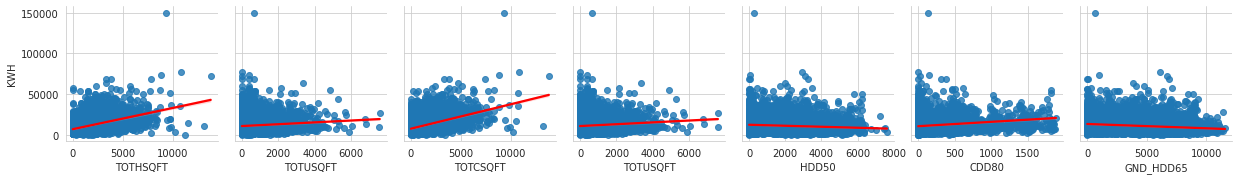

In [15]:
# Do these variables seem to be correlated with KWH? 
sns.pairplot(
    data,
    x_vars=con_cols[7:14],
    y_vars=['KWH'],
    kind="reg", 
    plot_kws={'line_kws':{'color':'red'}}
)

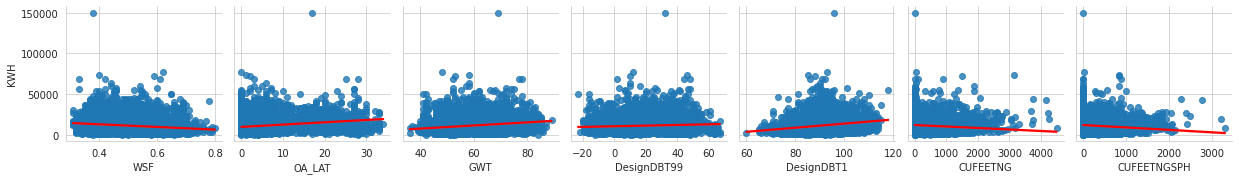

In [16]:
# Do these variables seem to be correlated with KWH? 
sns.pairplot(
    data,
    x_vars=con_cols[14:21],
    y_vars=['KWH'],
    kind="reg", 
    plot_kws={'line_kws':{'color':'red'}}
)

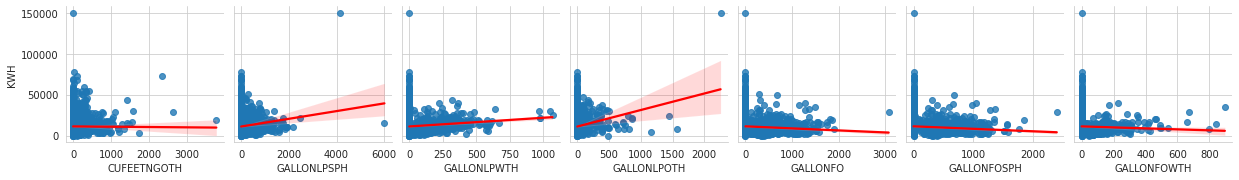

In [17]:
# Do these variables seem to be correlated with KWH? 
sns.pairplot(
    data,
    x_vars=con_cols[21:28],
    y_vars=['KWH'],
    kind="reg", 
    plot_kws={'line_kws':{'color':'red'}}
)

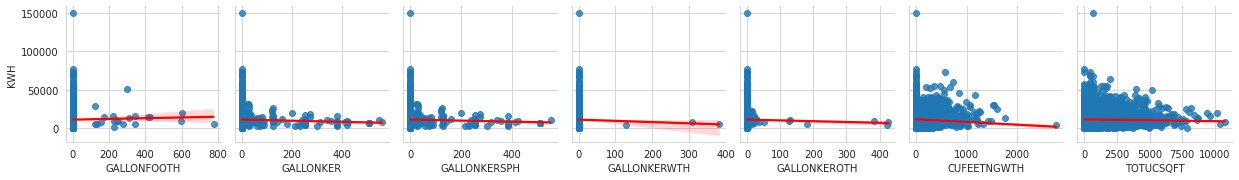

In [18]:
# Do these variables seem to be correlated with KWH? 
sns.pairplot(
    data,
    x_vars=con_cols[28:],
    y_vars=['KWH'],
    kind="reg", 
    plot_kws={'line_kws':{'color':'red'}}
)

In [19]:
ctg_cols = set(data.columns) - set(data[con_cols + ['KWH']].columns) # Get the categorical data

In [20]:
# Perform One Hot Encoding
ctg_dummies = pd.get_dummies(data[ctg_cols].astype(object)) 

In [21]:
ctg_dummies # Ok so this gives us way too many columns - Let's remove the columns where more than 75% of the values are the same

,AUTOHEATDAY_-2,AUTOHEATDAY_0,AUTOHEATDAY_1,HEATOTH_-2,HEATOTH_0,HEATOTH_1,USEOTH_0,USEOTH_1,NUMFREEZ_-2,NUMFREEZ_1,...,YEARMADE_2000,YEARMADE_2001,YEARMADE_2002,YEARMADE_2003,YEARMADE_2004,YEARMADE_2005,YEARMADE_2006,YEARMADE_2007,YEARMADE_2008,YEARMADE_2009
0,0,0,1,0,1,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,0,0,1,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
12079,0,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12080,0,0,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
12081,0,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# Get a series where more than 75% of the values are the same in the column
# 75% of 12083 is 9062
filtered_df = ctg_dummies.sum()[ctg_dummies.sum() > 9062].to_frame()
# Get the first column and remove _* to get the column name
cols_to_remove = filtered_df.index.str.split('_').str[:-1].str.join('_') 
# We want get the first column and remove everything after _
# But we want to be careful because some column names have _ in their name so we 
# want to remove everything after the last _

In [23]:
cols_to_remove

Index(['HEATOTH', 'USEOTH', 'EQUIPNOHEAT', 'PCTATTCL', 'AGEHHMEMCAT14',
       'OTHCOOK', 'LPGDELV', 'KRWATER', 'WHEATBKT', 'OTHERSTB2',
       ...
       'POOL', 'REPLCWWAC', 'METROMICRO', 'MONRFRI2', 'TVONWDWATCH3',
       'HELPFRIY', 'OTHWATER', 'OTHERWAYEL', 'WOODAMT', 'SCALEKER'],
      dtype='object', length=248)

In [24]:
data = data.drop(cols_to_remove, axis = 1) # Get an updated df

In [25]:
data # 270 columns remaining

,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,Climate_Region_Pub,...,SCALENG,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,2,4,12,2,2471.68,4742,1080,4953,1271,4,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,4,10,26,2,8599.17,2662,199,2688,143,5,...,0,3C,62,26,2393,0.61,0,64,38,73
2,1,1,1,5,8969.92,6233,505,5741,829,1,...,3,5A,2346,49,5654,0.48,3,52,12,88
3,2,3,7,2,18003.64,6034,672,5781,868,1,...,3,5A,2746,0,4941,0.55,4,55,7,87
4,1,1,1,3,5999.61,5388,702,5313,797,1,...,0,5A,2251,0,5426,0.61,4,50,13,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,2,3,9,2,10219.80,7671,332,7784,451,1,...,3,6A-6B,4289,39,7819,0.59,0,48,-3,84
12079,3,7,21,4,8689.07,2085,2844,2520,2286,2,...,0,3B-4B,360,393,1869,0.50,0,56,26,101
12080,2,4,10,2,4697.21,7935,472,8074,600,1,...,0,6A-6B,4494,22,8477,0.58,1,46,-9,89
12081,4,8,23,2,13155.68,5834,770,5989,957,1,...,0,5B-5C,2840,0,9010,0.54,1,53,13,93


In [26]:
# What does the updated one hot encoding look like? 

# Get the categorical data
ctg_cols = set(data.columns) - set(data[con_cols + ['KWH']].columns) 
# Perform One Hot Encoding
ctg_dummies = pd.get_dummies(data[ctg_cols].astype(object)) 

ctg_dummies

,AUTOHEATDAY_-2,AUTOHEATDAY_0,AUTOHEATDAY_1,NUMFREEZ_-2,NUMFREEZ_1,NUMFREEZ_2,NUMFREEZ_3,ELFOOD_0,ELFOOD_1,COMBOVCRDVD1_-2,...,YEARMADE_2000,YEARMADE_2001,YEARMADE_2002,YEARMADE_2003,YEARMADE_2004,YEARMADE_2005,YEARMADE_2006,YEARMADE_2007,YEARMADE_2008,YEARMADE_2009
0,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12079,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
12080,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
12081,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# Ok so it looks like we still have a lot of columns, what variables have the most values? 
ctg_cols = ctg_dummies.columns.to_frame().index.str.split('_').str[:-1].str.join('_')
ctg_cols.to_frame().iloc[:, 0].value_counts()

YEARMADE    90
HHAGE       69
TEMPNITE    45
TEMPGONE    43
TEMPHOME    40
            ..
SLDDRS       2
STEREO       2
ANSMACH      2
UGWATER      2
HHSEX        2
Name: 0, Length: 235, dtype: int64

In [28]:
# So it looks like some of these can be considered as continuous since there are a lot of different values
# Lets take a look at the ones that have more than 10 unique values
ctg_df = ctg_cols.to_frame().iloc[:, 0].value_counts().to_frame()
ctg_df[ctg_df.iloc[:, 0] >= 10]

,0
YEARMADE,90
HHAGE,69
TEMPNITE,45
TEMPGONE,43
TEMPHOME,40
TEMPGONEAC,37
TEMPNITEAC,37
LGT1,34
TEMPHOMEAC,30
LGT1EE,29


In [29]:
# All of these look like they can be continuous other than REPORTABLE_DOMAIN & IECC_Climate_Pub
# Update the continuous columns list
con_cols = ctg_df[ctg_df.iloc[:, 0] >= 10].index.\
  drop(['REPORTABLE_DOMAIN', 'IECC_Climate_Pub']).tolist() + con_cols
# Get a list of the categorical data
ctg_cols = ctg_df[ctg_df.iloc[:, 0] < 10].index.tolist() + \
  ['REPORTABLE_DOMAIN', 'IECC_Climate_Pub']# Get the categorical data

In [30]:
data[con_cols + ['KWH']] # Continuous and y variable

,YEARMADE,HHAGE,TEMPNITE,TEMPGONE,TEMPHOME,TEMPGONEAC,TEMPNITEAC,LGT1,TEMPHOMEAC,LGT1EE,...,GALLONFOSPH,GALLONFOWTH,GALLONFOOTH,GALLONKER,GALLONKERSPH,GALLONKERWTH,GALLONKEROTH,CUFEETNGWTH,TOTUCSQFT,KWH
0,2004,35,68,66,68,78,73,2,74,2,...,0.0,0.0,0.0,0,0,0,0,0.00,1118,18466
1,1998,40,73,70,70,-2,-2,0,-2,-2,...,0.0,0.0,0.0,0,0,0,0,293.76,400,5148
2,1965,45,65,60,68,-2,-2,2,-2,2,...,0.0,0.0,0.0,0,0,0,0,77.39,264,2218
3,1985,75,55,55,55,74,68,0,74,-2,...,0.0,0.0,0.0,0,0,0,0,0.00,400,10015
4,1983,40,70,70,70,-2,-2,2,-2,2,...,0.0,0.0,0.0,0,0,0,0,135.45,1912,2869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,1985,36,60,60,65,-2,-2,4,-2,4,...,0.0,0.0,0.0,0,0,0,0,0.00,1667,7647
12079,1980,26,90,50,70,-2,-2,1,-2,0,...,0.0,0.0,0.0,0,0,0,0,35.56,0,1813
12080,1993,38,65,62,65,-2,-2,0,-2,-2,...,0.0,0.0,0.0,0,0,0,0,237.96,400,9834
12081,1930,69,64,62,66,-2,-2,4,-2,0,...,0.0,0.0,0.0,0,0,0,0,121.13,1210,4800


In [31]:
pd.get_dummies(data[ctg_cols].astype(object)) # Categorical values 

,HELPFRI_-9,HELPFRI_-8,HELPFRI_-2,HELPFRI_0,HELPFRI_1,HELPFRI_2,HELPFRI_3,HELPFRI_4,HELPFRI_5,NCOMBATH_0,...,IECC_Climate_Pub_2B,IECC_Climate_Pub_3A,IECC_Climate_Pub_3B-4B,IECC_Climate_Pub_3C,IECC_Climate_Pub_4A,IECC_Climate_Pub_4C,IECC_Climate_Pub_5A,IECC_Climate_Pub_5B-5C,IECC_Climate_Pub_6A-6B,IECC_Climate_Pub_7A-7B-7AK-8AK
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12079,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
12080,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12081,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [32]:
# Create the design matrix
# Leave the continuous variables as they are and perform one hot encoding on the categorical data
X = pd.concat([data[con_cols], pd.get_dummies(data[ctg_cols].astype(object))], \
              axis = 1)
# Y variable
Y = data['KWH']

In [33]:
# Let's also create a new design matrix using a PCA transformation
# This will help us with both dimensionality reducation and correlation among variables
X_standardized = pd.DataFrame(StandardScaler().fit_transform(X), index = X.index, \
                     columns = X.columns)

In [34]:
# Let's pick the optimal number of Prinicpal Components 
# This will explain 75% of the variation
pca75 = PCA(n_components = 0.75)
principalComponents75 = pca75.fit_transform(X_standardized)
x_pca75 = pd.DataFrame(principalComponents75)
# This will explain 80% of the variation
pca80 = PCA(n_components = 0.8)
principalComponents80 = pca80.fit_transform(X_standardized)
x_pca80 = pd.DataFrame(principalComponents80)
# 85% of the variation
pca85 = PCA(n_components = 0.85)
principalComponents85 = pca85.fit_transform(X_standardized)
x_pca85 = pd.DataFrame(principalComponents85)
# 90%
pca90 = PCA(n_components = 0.9)
principalComponents90 = pca90.fit_transform(X_standardized)
x_pca90 = pd.DataFrame(principalComponents90)
# 95%
pca95 = PCA(n_components = 0.95)
principalComponents95 = pca95.fit_transform(X_standardized)
x_pca95 = pd.DataFrame(principalComponents95)
# 99%
pca99 = PCA(n_components = 0.99)
principalComponents99 = pca99.fit_transform(X_standardized)
x_pca99 = pd.DataFrame(principalComponents99)

So we have the following number of columns for variance explained:  
75% - 227 Columns  
80% - 270 Columns  
85% - 318 Columns  
90% - 372 Columns  
95% - 438 Columns  
99% - 519 Columns  
So, based on this I think that 80% of the variation is a good pick. It significantly reduces the number of columns while also explaining a lot of the variation. 

In [35]:
# Create a list for the PCs
pca_col_names = []
for i in range(270): 
  pca_col_names.append('PC' + str(i + 1))
# Create the Final PCA DataFrame
X_pca = pd.DataFrame(principalComponents80, index = X_standardized.index, \
                     columns = pca_col_names)

In [36]:
X_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC261,PC262,PC263,PC264,PC265,PC266,PC267,PC268,PC269,PC270
0,-11.691451,-4.943957,1.178386,-0.718943,-6.016093,-4.150723,2.749740,-2.790105,1.450400,-3.360215,...,-0.908080,-0.554680,1.954024,0.386286,2.381747,0.770836,-0.697169,-1.359226,1.701880,-0.527195
1,-0.857772,3.265146,-4.845224,7.157272,-0.762780,1.841875,-4.389846,-0.658695,-0.559267,-3.665437,...,0.380647,0.672699,-0.703851,-0.354646,0.913395,-1.862820,-0.205282,0.022494,0.965614,1.143975
2,15.176330,6.341374,-2.437768,3.445082,-5.602521,-3.653768,2.011552,1.244930,-0.746581,4.588640,...,0.450909,0.558990,0.107836,1.128733,0.091448,0.689499,0.107572,0.691821,0.025415,-0.239426
3,-6.461653,-1.894898,-2.284477,-2.211797,0.118644,-3.470874,0.323775,-3.216875,0.693813,-2.192740,...,-0.193162,0.199972,-0.126750,-0.636826,0.368965,-0.076016,0.583947,1.239785,0.790093,-1.340572
4,0.113908,7.496470,4.292725,0.568391,-3.854429,2.073334,-4.867001,-0.036774,3.220008,-2.428560,...,0.256379,1.244265,1.593250,0.762002,1.107155,0.239005,0.079154,-0.023727,-0.310196,0.974519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,-4.374224,2.527504,8.372050,2.094259,-0.902630,-4.902888,-3.470891,-2.913510,-3.497205,-1.059967,...,-2.345433,0.728911,-0.321742,1.414469,1.136185,-0.643152,0.148510,-0.410235,-0.286754,-2.295807
12079,14.340915,0.687060,-3.692395,6.887302,4.985241,-1.702438,3.536712,2.525407,-1.044564,-1.318163,...,-0.577120,-0.027284,0.680177,-0.395833,-0.117822,-0.413743,0.696857,0.993925,-0.291595,1.304276
12080,-11.378292,6.019543,-2.764944,3.363876,-0.321596,-3.979266,1.762506,-3.444558,-1.166599,-2.507641,...,-1.169662,0.203605,-1.005475,-0.042016,0.889307,0.591342,-0.718763,-0.614385,-0.846784,0.029490
12081,0.420663,5.451853,3.386730,3.189810,3.901598,-2.860566,-6.472471,-0.561629,1.376274,-3.614723,...,0.093220,-0.011062,1.369184,-1.404249,-1.454596,0.624740,0.051133,-0.576528,0.007843,1.599527


## Machine Learning

### Literature Review
Based on some studies conducted in other report, it seems like a good start for which algorithms we should start off with are:  
* Linear Regression  
* Support Vector Machine  
* Random Forest  
* KNN

Also, since we have a lot of columns, we can also try PCA. We can try using the PCAs for the predictors along with the regular columns to see how they compare. Also, we can try a LASSO regression with the regular columns since we can tune the penalty to adjust the number of columns. We will also try fitting a Ridge Regression model.

**Note: The articles I went over are provided in the appendix**

In [37]:
#Import libraries for machine learning 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

### Models with PCA Design Matrix

In [38]:
# Create a training and testing set
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, Y,
                                                                    test_size = 0.2,
                                                                    random_state = 0)

#### Linear Regression with PCA Predictors

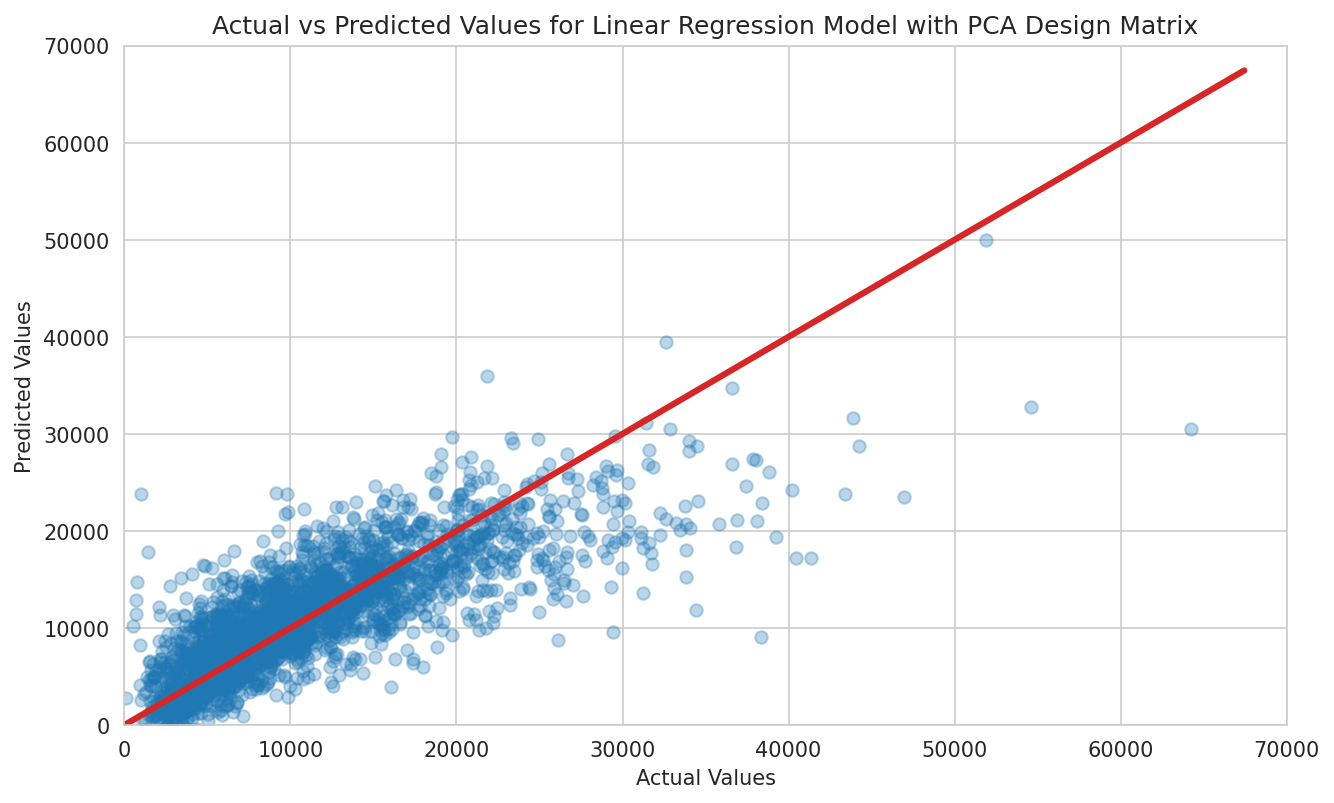

In [39]:
# Create the Linear Regression Instance
pca_regressor = LinearRegression()
# Fit the model
pca_regressor.fit(X_pca_train, y_pca_train)
# Get the predictions
y_pca_pred = pca_regressor.predict(X_pca_test)

# Plot the predictions vs actual
plt.figure(figsize=(10,6), dpi = 150)
plt.scatter(y_pca_test, y_pca_pred, alpha = 0.3)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, color='tab:red', lw=3, 
         scalex=False, scaley=False)
plt.xlabel('Actual Values')
plt.xlim(0, 70000)
plt.ylabel('Predicted Values')
plt.ylim(0, 70000)
plt.title('Actual vs Predicted Values for Linear Regression Model with PCA Design Matrix')
plt.show()

In [40]:
# How well does this model fit? 
# Let's use RMSE to compare the models 
# First we will get the SD of the test data
np.std(y_pca_test)

7314.747134489998

In [41]:
# Now, the RMSE
mean_squared_error(y_pca_test, y_pca_pred, squared = False)

4512.109369848559

So, with the SD, we can think of this as - 'How well does our model do if we predict the mean for each prediction'. Therefore, when we compare the RMSE to the SD, we are testing how much better is our model than predicting the average value each time. In this case, our model is $$\frac{7314.75 - 4512.11}{7314.75}*100 \approx  38.3\% $$ better than predicting the average. 

#### Support Vector Machine with PCA

In [42]:
# We will create our default scorer. Since we are using RMSE to compare between model, we will also use that to compare the hyperparameters
scorer = make_scorer(mean_squared_error, greater_is_better = False)
# Create the parameter grid
svr_param_grid = {'C': [0.1, 1, 3, 10, 30, 100],
                  'epsilon': [0.001, 0.01, 0.1, 1]}
# Create the SVR instance
# We will use Linear SVR since that scales better and the regular SVR will
# take a lot longer. 
svm_pca = LinearSVR(random_state = 0)
# Create the Grid Search
svr_gc = GridSearchCV(estimator = svm_pca, 
                            param_grid = svr_param_grid,
                            cv = 5,
                            verbose = 3,
                            n_jobs = -1,
                            scoring = scorer)

In [43]:
# Tune the parameters
search = svr_gc.fit(X_pca_train, y_pca_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [44]:
pd.DataFrame(search.cv_results_) # The results of the cv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.137444,0.050784,0.008444,0.001771,0.1,0.001,"{'C': 0.1, 'epsilon': 0.001}",-1.670553e+08,-1.824931e+08,-1.691319e+08,-1.745045e+08,-1.625063e+08,-1.711382e+08,6.862493e+06,21
1,0.078818,0.006859,0.007144,0.000150,0.1,0.01,"{'C': 0.1, 'epsilon': 0.01}",-1.670553e+08,-1.824931e+08,-1.691320e+08,-1.745045e+08,-1.625063e+08,-1.711382e+08,6.862509e+06,22
2,0.078868,0.007890,0.007384,0.000104,0.1,0.1,"{'C': 0.1, 'epsilon': 0.1}",-1.670552e+08,-1.824934e+08,-1.691322e+08,-1.745044e+08,-1.625061e+08,-1.711383e+08,6.862666e+06,23
3,0.085694,0.010529,0.007338,0.000404,0.1,1,"{'C': 0.1, 'epsilon': 1}",-1.670544e+08,-1.824968e+08,-1.691351e+08,-1.745037e+08,-1.625037e+08,-1.711387e+08,6.864238e+06,24
4,0.128673,0.004583,0.008289,0.002013,1,0.001,"{'C': 1, 'epsilon': 0.001}",-5.571359e+07,-6.639581e+07,-5.625714e+07,-6.051107e+07,-5.235139e+07,-5.824580e+07,4.830428e+06,18
5,0.131866,0.005561,0.009510,0.002578,1,0.01,"{'C': 1, 'epsilon': 0.01}",-5.571355e+07,-6.639583e+07,-5.625714e+07,-6.051108e+07,-5.235140e+07,-5.824580e+07,4.830436e+06,19
6,0.144406,0.010539,0.007634,0.000429,1,0.1,"{'C': 1, 'epsilon': 0.1}",-5.569438e+07,-6.638772e+07,-5.618931e+07,-6.051121e+07,-5.242372e+07,-5.824127e+07,4.817851e+06,17
7,0.133406,0.006003,0.007579,0.000164,1,1,"{'C': 1, 'epsilon': 1}",-5.570968e+07,-6.641411e+07,-5.625888e+07,-6.058788e+07,-5.237874e+07,-5.826986e+07,4.837477e+06,20
8,0.249582,0.023026,0.007510,0.000162,3,0.001,"{'C': 3, 'epsilon': 0.001}",-2.889208e+07,-3.740381e+07,-2.933774e+07,-3.412193e+07,-2.885123e+07,-3.172136e+07,3.463440e+06,16
9,0.242681,0.022186,0.007454,0.000238,3,0.01,"{'C': 3, 'epsilon': 0.01}",-2.889078e+07,-3.738682e+07,-2.933774e+07,-3.412195e+07,-2.884144e+07,-3.171575e+07,3.459709e+06,15


In [45]:
# What are the best parameters? 
search.best_params_

{'C': 30, 'epsilon': 0.1}

In [46]:
# Create a new SVR instance with the tuned parameters
svr_final = LinearSVR(epsilon = 0.1, 
                      C = 30, 
                      random_state = 0)

In [47]:
# Fit the model
svr_final.fit(X_pca_train, y_pca_train)

LinearSVR(C=30, epsilon=0.1, random_state=0)

In [48]:
# Get the predicted values
y_pca_svr_pred = svr_final.predict(X_pca_test)

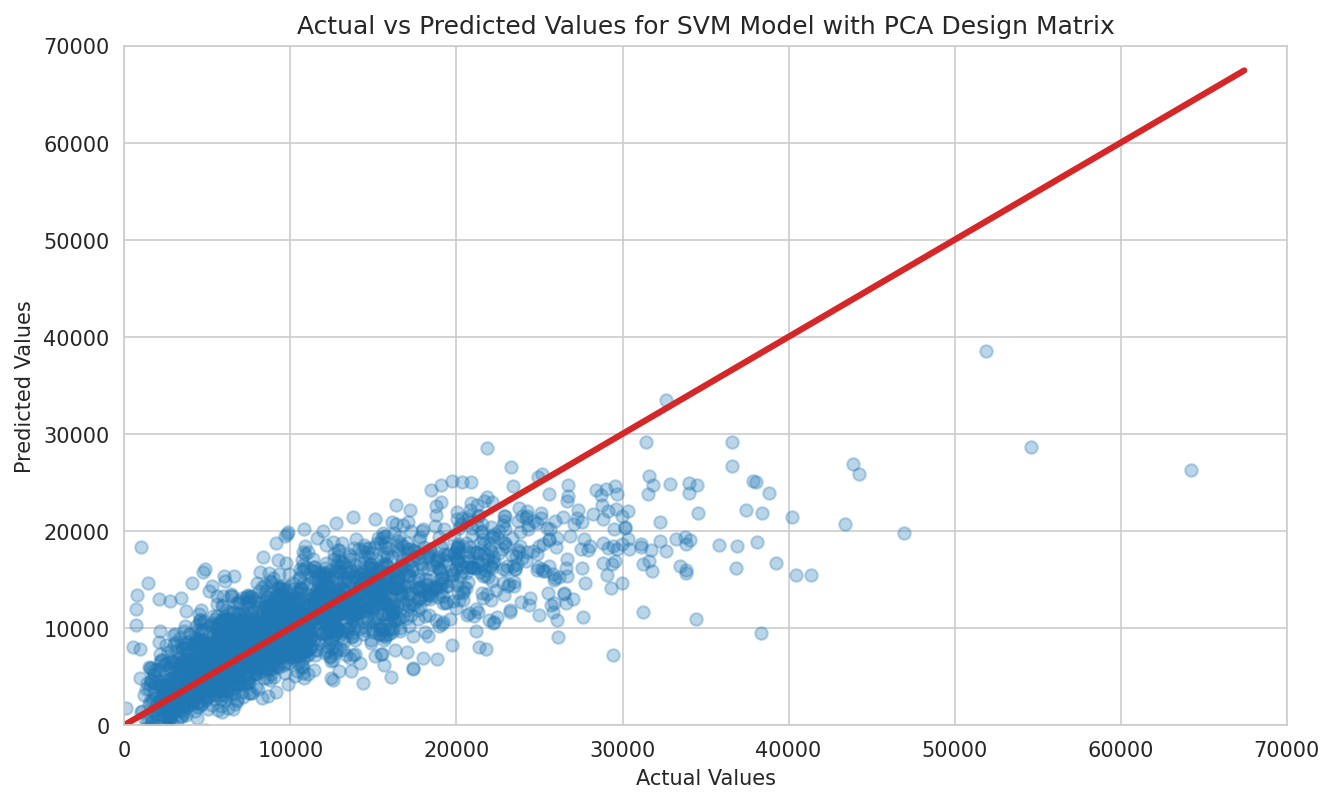

In [49]:
# What does the plot look like
plt.figure(figsize=(10,6), dpi = 150)
plt.scatter(y_pca_test, y_pca_svr_pred, alpha = 0.3)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, color='tab:red', lw=3, 
         scalex=False, scaley=False)
plt.xlabel('Actual Values')
plt.xlim(0, 70000)
plt.ylabel('Predicted Values')
plt.ylim(0, 70000)
plt.title('Actual vs Predicted Values for SVM Model with PCA Design Matrix')
plt.show()

In [50]:
# What is the rmse for this model?
mean_squared_error(y_pca_test, y_pca_svr_pred, squared = False)

4541.227231934233

This model has a performace similar to that of the Linear Model (based off the RMSE)

#### Random Forest with PCA

In [51]:
# Create the parameter grid and the RF instance 
rf_param_grid = {
    'n_estimators': [100, 150, 250, 500],
    'max_depth': [2, 5, 10, 20],
    'min_samples_leaf': [1, 3, 4, 5, 6],
    'min_samples_split': [2, 6, 8, 10, 12],
    'max_features': ['sqrt', 'log2']
}
rf_pca = RandomForestRegressor(random_state = 0)
# Create the Grid Search
rf_gc = RandomizedSearchCV(estimator = rf_pca, # Use random Search because the time to fit the others takes too long
                            param_distributions = rf_param_grid,
                            cv = 3,
                            verbose = 5,
                            n_jobs = -1,
                            scoring = scorer,
                            n_iter = 25) # Change the number of iterations to improve performance
# It isn't too bad of an idea because we don't expect random forest to do that well anyway
# because we have a lot of predictors (since not all of them will be useful, that will impact the ability of the rf)

In [52]:
# Tune the hyperparameters
search_rf = rf_gc.fit(X_pca_train, y_pca_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [53]:
# Results of the CV
pd.DataFrame(search_rf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.424256,0.011629,0.038759,0.003629,100,10,6,log2,2,"{'n_estimators': 100, 'min_samples_split': 10,...",-5.363341e+07,-5.890878e+07,-5.756228e+07,-5.670149e+07,2.238020e+06,23
1,1.389973,0.015612,0.035082,0.001919,100,8,3,log2,2,"{'n_estimators': 100, 'min_samples_split': 8, ...",-5.391346e+07,-5.887784e+07,-5.769639e+07,-5.682923e+07,2.117426e+06,25
2,2.070866,0.009213,0.044339,0.002099,150,10,3,log2,2,"{'n_estimators': 150, 'min_samples_split': 10,...",-5.385331e+07,-5.888745e+07,-5.771052e+07,-5.681709e+07,2.150087e+06,24
3,39.548931,0.914623,0.541169,0.011665,500,8,4,log2,20,"{'n_estimators': 500, 'min_samples_split': 8, ...",-3.816483e+07,-4.229166e+07,-4.162674e+07,-4.069441e+07,1.809166e+06,14
4,14.126786,0.343659,0.093990,0.004863,250,6,6,sqrt,5,"{'n_estimators': 250, 'min_samples_split': 6, ...",-4.419357e+07,-4.891135e+07,-4.756469e+07,-4.688987e+07,1.984253e+06,15
5,4.473536,0.045855,0.056191,0.002174,150,6,5,log2,5,"{'n_estimators': 150, 'min_samples_split': 6, ...",-4.868643e+07,-5.311268e+07,-5.206022e+07,-5.128644e+07,1.888027e+06,20
6,14.900942,0.315420,0.121516,0.002392,100,6,3,sqrt,20,"{'n_estimators': 100, 'min_samples_split': 6, ...",-3.276849e+07,-3.667303e+07,-3.718300e+07,-3.554151e+07,1.971842e+06,2
7,14.000769,0.238986,0.113398,0.001283,100,6,5,sqrt,20,"{'n_estimators': 100, 'min_samples_split': 6, ...",-3.267411e+07,-3.787902e+07,-3.721144e+07,-3.592152e+07,2.312385e+06,5
8,2.957022,0.024697,0.040368,0.000285,100,12,4,log2,5,"{'n_estimators': 100, 'min_samples_split': 12,...",-4.830148e+07,-5.249864e+07,-5.173523e+07,-5.084512e+07,1.825427e+06,18
9,27.971020,0.094360,0.171189,0.010559,500,8,1,sqrt,5,"{'n_estimators': 500, 'min_samples_split': 8, ...",-4.517023e+07,-4.878768e+07,-4.898035e+07,-4.764609e+07,1.752463e+06,17


In [54]:
# What are the optimal parameter values
search_rf.best_params_

{'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 250}

In [56]:
# Fit the final model
rf_final = RandomForestRegressor(n_estimators = 250,
                                 max_depth = 20,
                                 min_samples_leaf = 1,
                                 min_samples_split = 6,
                                 max_features = 'sqrt',
                                 random_state = 0)

rf_final.fit(X_pca_train, y_pca_train)
# Get the perdicted values
rf_pca_pred = rf_final.predict(X_pca_test)

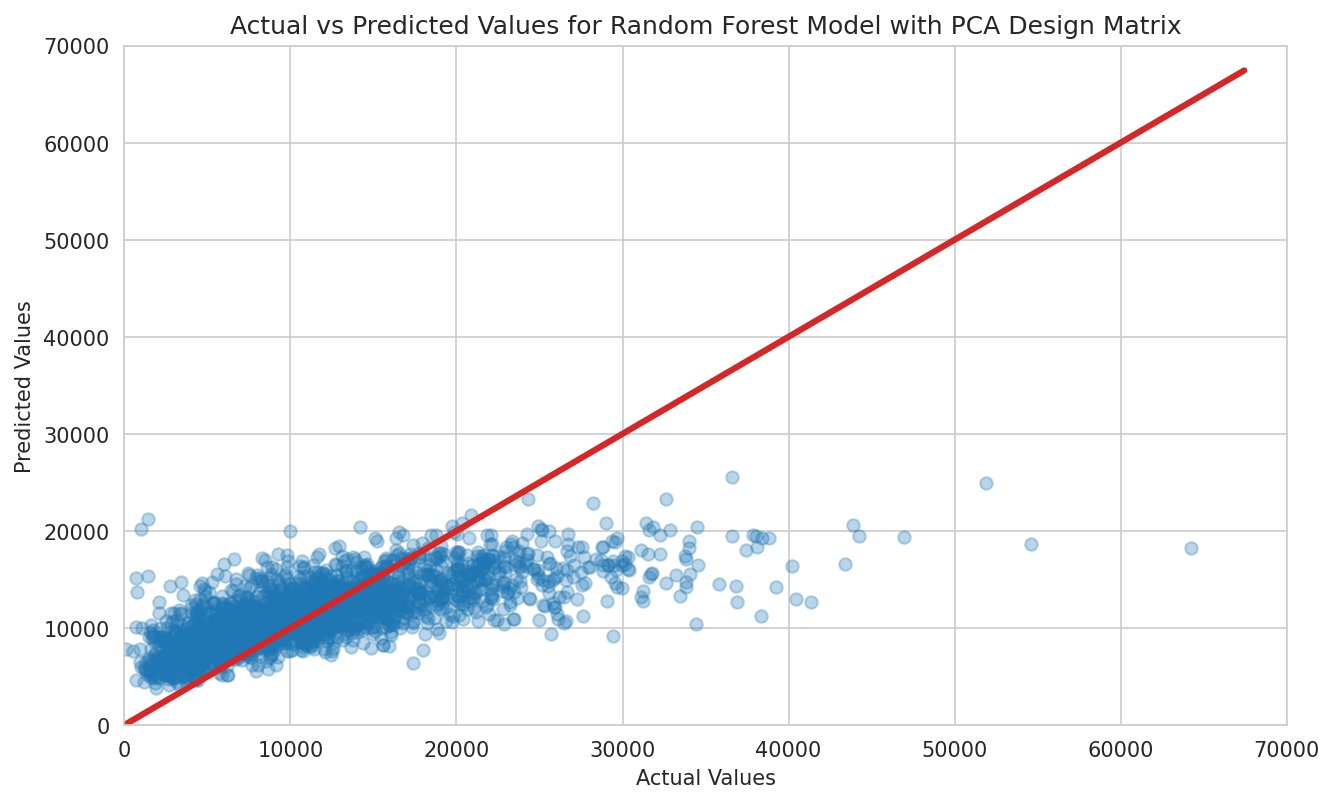

In [57]:
# Plot the values
plt.figure(figsize=(10,6), dpi = 150)
plt.scatter(y_pca_test, rf_pca_pred, alpha = 0.3)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, color='tab:red', lw=3, 
         scalex=False, scaley=False)
plt.xlabel('Actual Values')
plt.xlim(0, 70000)
plt.ylabel('Predicted Values')
plt.ylim(0, 70000)
plt.title('Actual vs Predicted Values for Random Forest Model with PCA Design Matrix')
plt.show()

In [58]:
# How is the performace of the model?
mean_squared_error(y_pca_test, rf_pca_pred, squared = False)

5413.222096037951

As noted above, it isn't too surprising that the random forest doesn't perform as well as the other models. With the random forest, we are randomly picking predictors to use but since we have a lot of features in this dataset, there is a high probability that the 'best' features aren't being picked. 

#### KNN with PCA

In [59]:
# Create the parameter grid and the knn instance 
knn_parameter_grid = {
    'n_neighbors': [3, 5, 7, 10, 15, 20, 30, 50],
    'leaf_size': [3, 5, 10, 20, 30, 40, 50]
}
knn_pca = KNeighborsRegressor()
# Create the grid search 
knn_gc = GridSearchCV(estimator = knn_pca, 
                            param_grid = knn_parameter_grid,
                            cv = 5,
                            verbose = 3,
                            n_jobs = -1,
                            scoring = scorer)

In [60]:
# Tune the hyperparameters
search_knn = knn_gc.fit(X_pca_train, y_pca_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


In [61]:
# Results of the CV
pd.DataFrame(search_knn.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_leaf_size,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.028252,0.008831,0.864235,0.069477,3,3,"{'leaf_size': 3, 'n_neighbors': 3}",-2.971255e+07,-4.424555e+07,-3.227520e+07,-3.521378e+07,-3.085553e+07,-3.446052e+07,5.227408e+06,50
1,0.020689,0.002086,0.901156,0.010449,3,5,"{'leaf_size': 3, 'n_neighbors': 5}",-2.746554e+07,-4.106776e+07,-3.030475e+07,-3.346184e+07,-2.760501e+07,-3.198098e+07,5.042036e+06,43
2,0.018620,0.000557,0.904606,0.005694,3,7,"{'leaf_size': 3, 'n_neighbors': 7}",-2.683430e+07,-4.079353e+07,-2.894090e+07,-3.281622e+07,-2.759725e+07,-3.139644e+07,5.130258e+06,36
3,0.019649,0.000966,0.907267,0.010009,3,10,"{'leaf_size': 3, 'n_neighbors': 10}",-2.607064e+07,-3.957308e+07,-2.830707e+07,-3.203369e+07,-2.694943e+07,-3.058678e+07,4.932952e+06,15
4,0.024258,0.007120,0.942857,0.045180,3,15,"{'leaf_size': 3, 'n_neighbors': 15}",-2.610514e+07,-3.919724e+07,-2.831853e+07,-3.187108e+07,-2.687979e+07,-3.047435e+07,4.789530e+06,1
5,0.023928,0.004888,0.919072,0.004553,3,20,"{'leaf_size': 3, 'n_neighbors': 20}",-2.614637e+07,-3.933093e+07,-2.795814e+07,-3.229868e+07,-2.678371e+07,-3.050356e+07,4.908085e+06,8
6,0.025534,0.005494,0.921142,0.014867,3,30,"{'leaf_size': 3, 'n_neighbors': 30}",-2.638970e+07,-3.944999e+07,-2.829087e+07,-3.236892e+07,-2.675428e+07,-3.065075e+07,4.884399e+06,22
7,0.021046,0.002509,0.932478,0.006991,3,50,"{'leaf_size': 3, 'n_neighbors': 50}",-2.689206e+07,-3.982691e+07,-2.887110e+07,-3.303980e+07,-2.713254e+07,-3.115248e+07,4.864637e+06,29
8,0.026728,0.007559,0.826753,0.019334,5,3,"{'leaf_size': 5, 'n_neighbors': 3}",-2.971255e+07,-4.424555e+07,-3.227520e+07,-3.521378e+07,-3.085553e+07,-3.446052e+07,5.227408e+06,50
9,0.022193,0.004631,0.914663,0.018636,5,5,"{'leaf_size': 5, 'n_neighbors': 5}",-2.746554e+07,-4.106776e+07,-3.030475e+07,-3.346184e+07,-2.760501e+07,-3.198098e+07,5.042036e+06,43


In [62]:
# What are the optimal parameter values
search_knn.best_params_

{'leaf_size': 3, 'n_neighbors': 15}

In [63]:
# Fit the final model
knn_final = KNeighborsRegressor(n_neighbors = 15,
                                leaf_size = 3)

knn_final.fit(X_pca_train, y_pca_train)
# Get the perdicted values
knn_pca_pred = knn_final.predict(X_pca_test)

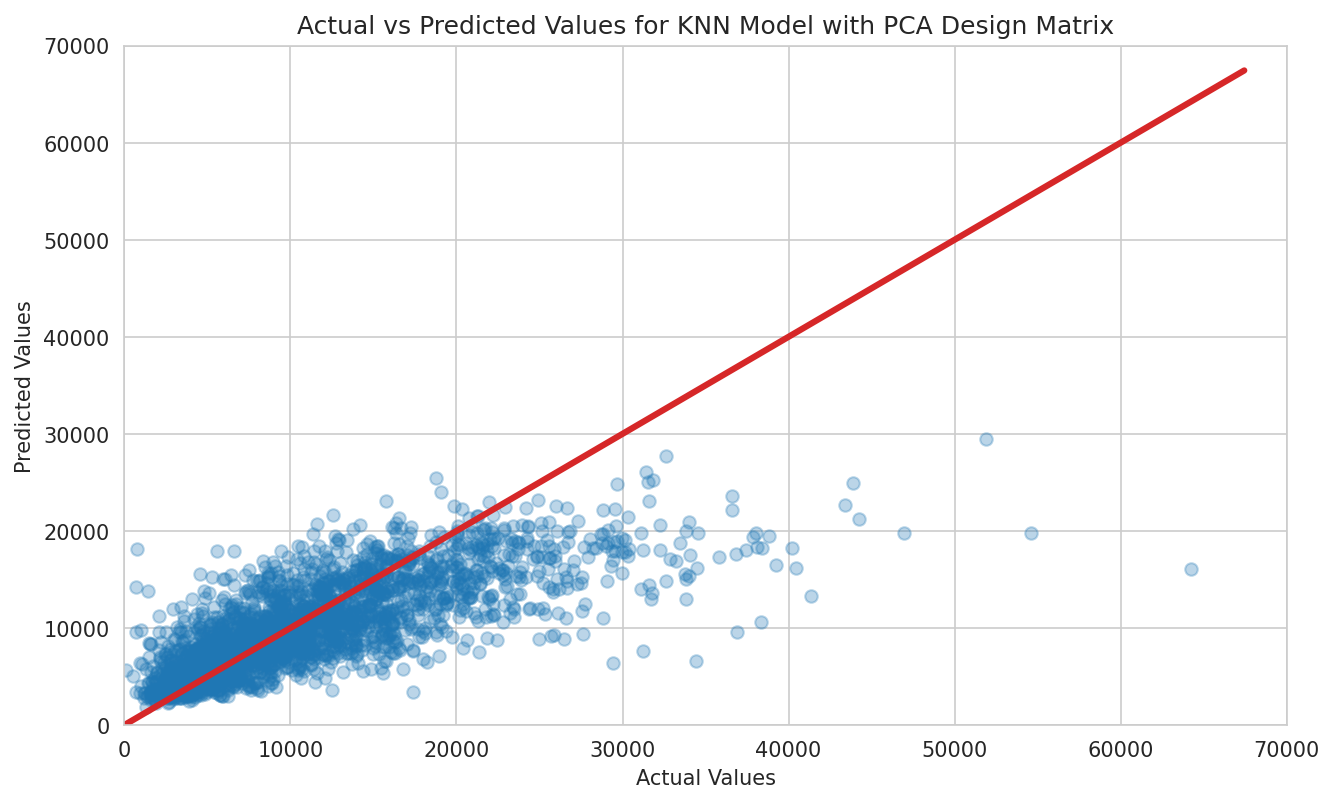

In [64]:
# Plot the values
plt.figure(figsize=(10,6), dpi = 150)
plt.scatter(y_pca_test, knn_pca_pred, alpha = 0.3)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, color='tab:red', lw=3, 
         scalex=False, scaley=False)
plt.xlabel('Actual Values')
plt.xlim(0, 70000)
plt.ylabel('Predicted Values')
plt.ylim(0, 70000)
plt.title('Actual vs Predicted Values for KNN Model with PCA Design Matrix')
plt.show()

In [65]:
# Model Performance
mean_squared_error(y_pca_test, knn_pca_pred, squared = False)

5084.130600170309

#### LASSO Regression with PCA

Since the Lasso penalizes the predictors, we can tune the penalty to only include the 'most important' predictors. This means, the LASSO with the actual predictors (not the PCA) will probably do better than this. However, we will still fit this to confirm that hypothesis.

In [66]:
# Create the parameter grid and the LASSO instance 
lasso_parameter_grid = {
    'alpha': [0.01, 0.1, 1, 10, 20, 30, 40, 50, 100, 300, 500, 1000]
}
lasso_pca = Lasso(random_state = 0)
# Create the grid search 
lasso_gc = GridSearchCV(estimator = lasso_pca, 
                            param_grid = lasso_parameter_grid,
                            cv = 5,
                            verbose = 3,
                            n_jobs = -1,
                            scoring = scorer)

In [67]:
# Tune the hyperparameters
search_lasso = lasso_gc.fit(X_pca_train, y_pca_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [68]:
# Print the results
pd.DataFrame(search_lasso.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.131149,1.987652,0.010655,0.003120,0.01,{'alpha': 0.01},-2.181269e+07,-2.598851e+07,-2.195798e+07,-2.524251e+07,-4.168259e+07,-2.733686e+07,7.368216e+06,10
1,0.873809,1.541473,0.009300,0.000233,0.1,{'alpha': 0.1},-2.181104e+07,-2.599193e+07,-2.195736e+07,-2.524125e+07,-4.061547e+07,-2.712341e+07,6.953673e+06,9
2,0.499059,0.814049,0.009016,0.000128,1,{'alpha': 1},-2.179469e+07,-2.602588e+07,-2.195130e+07,-2.522880e+07,-3.285998e+07,-2.557213e+07,4.020346e+06,7
3,0.114254,0.076725,0.009214,0.000518,10,{'alpha': 10},-2.164845e+07,-2.633588e+07,-2.190175e+07,-2.512266e+07,-2.302175e+07,-2.360610e+07,1.834684e+06,5
4,0.112213,0.074324,0.008963,0.000094,20,{'alpha': 20},-2.152794e+07,-2.658950e+07,-2.186713e+07,-2.504268e+07,-2.265010e+07,-2.353547e+07,1.959397e+06,4
5,0.111914,0.069103,0.011207,0.003985,30,{'alpha': 30},-2.143792e+07,-2.686232e+07,-2.184811e+07,-2.499062e+07,-2.237244e+07,-2.350228e+07,2.087075e+06,2
6,0.099758,0.065997,0.008827,0.001551,40,{'alpha': 40},-2.136366e+07,-2.713384e+07,-2.185898e+07,-2.496656e+07,-2.210204e+07,-2.348502e+07,2.216558e+06,1
7,0.106552,0.060328,0.008687,0.001086,50,{'alpha': 50},-2.131676e+07,-2.743420e+07,-2.188963e+07,-2.496268e+07,-2.192178e+07,-2.350501e+07,2.343836e+06,3
8,0.071584,0.016598,0.010113,0.002943,100,{'alpha': 100},-2.135013e+07,-2.884629e+07,-2.217148e+07,-2.507819e+07,-2.168503e+07,-2.382623e+07,2.836279e+06,6
9,0.057058,0.005196,0.008489,0.000834,300,{'alpha': 300},-2.248195e+07,-3.308122e+07,-2.392688e+07,-2.690521e+07,-2.246442e+07,-2.577194e+07,3.996943e+06,8


In [69]:
# What are the most optimal parameters? 
search_lasso.best_params_

{'alpha': 40}

In [70]:
# Fit the final model
lasso_final = Lasso(alpha = 40,
                    random_state = 0)

lasso_final.fit(X_pca_train, y_pca_train)
# Get the perdicted values
lasso_pca_pred = lasso_final.predict(X_pca_test)

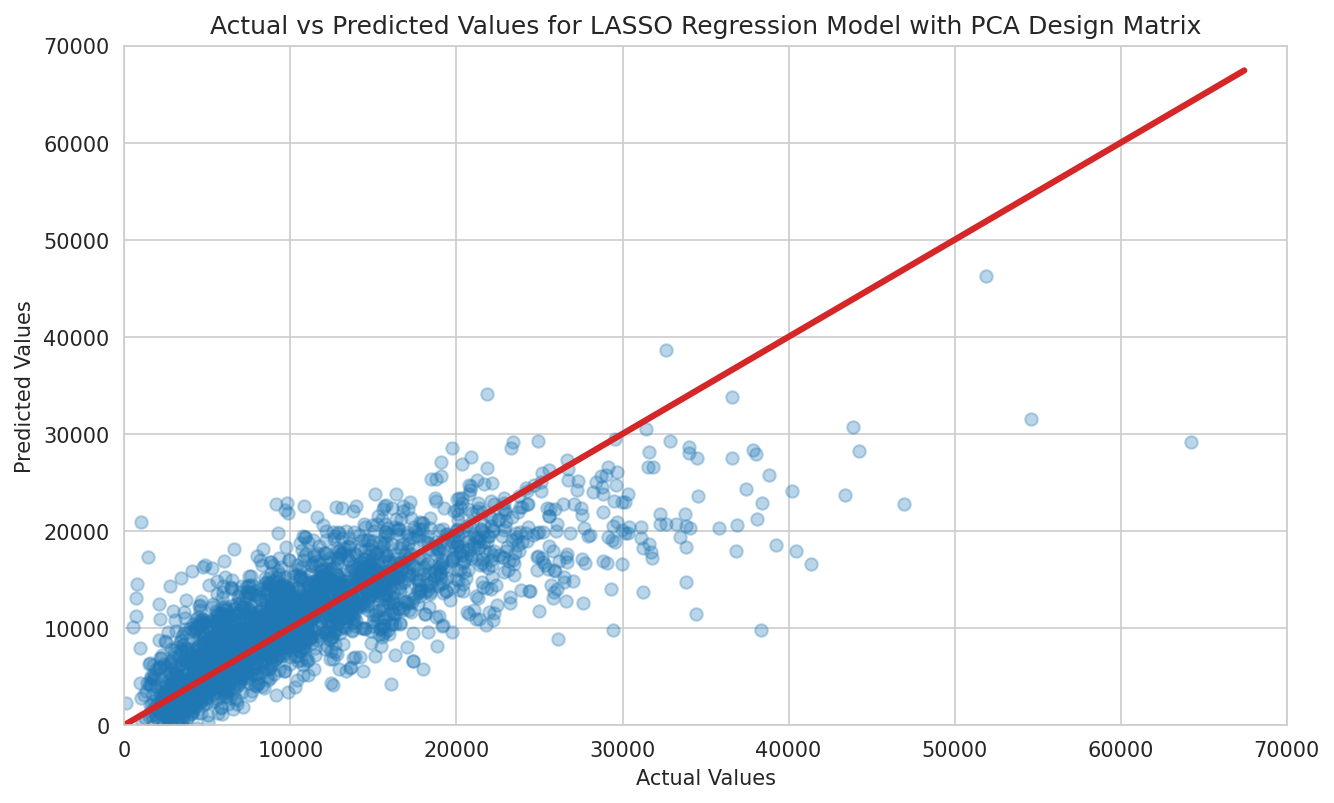

In [71]:
# Plot the data - actual vs predicted
plt.figure(figsize=(10,6), dpi = 150)
plt.scatter(y_pca_test, lasso_pca_pred, alpha = 0.3)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, color='tab:red', lw=3, 
         scalex=False, scaley=False)
plt.xlabel('Actual Values')
plt.xlim(0, 70000)
plt.ylabel('Predicted Values')
plt.ylim(0, 70000)
plt.title('Actual vs Predicted Values for LASSO Regression Model with PCA Design Matrix')
plt.show()

In [72]:
# How is the model performance
mean_squared_error(y_pca_test, lasso_pca_pred, squared = False)

4470.420600984905

So it does look like this model does pretty well. Clearly the fewer predictors we use, the better the results (this is showon in the results table above where the higher the penalty, the better the results). 

In [73]:
# How many predictors are we using?
sum(lasso_final.coef_ != 0)

221

So it does look like we are still using most of the PCAs (out of the 270 PCAs, the optimal model is using 221). But, since this model is one of the best, let's also try using ridge regression to see if that is any better. 

#### Ridge Regression with PCA

In [74]:
# Create the parameter grid and the Ridge instance 
ridge_parameter_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 30, 50, 100, 300, 500, 800, 900, 
              1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 5000]
}
ridge_pca = Ridge(random_state = 0)
# Create the grid search 
ridge_gc = GridSearchCV(estimator = ridge_pca, 
                            param_grid = ridge_parameter_grid,
                            cv = 5,
                            verbose = 3,
                            n_jobs = -1,
                            scoring = scorer)

In [75]:
# Tune the hyperparameters
search_ridge = ridge_gc.fit(X_pca_train, y_pca_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


In [76]:
# Print the results
pd.DataFrame(search_ridge.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.090083,0.007606,0.008728,0.001087,0.001,{'alpha': 0.001},-2.181288e+07,-2.598812e+07,-2.195805e+07,-2.524265e+07,-4.180258e+07,-2.736085e+07,7.414917e+06,21
1,0.086951,0.007041,0.009198,0.002228,0.01,{'alpha': 0.01},-2.181287e+07,-2.598812e+07,-2.195805e+07,-2.524265e+07,-4.179924e+07,-2.736019e+07,7.413616e+06,20
2,0.080400,0.001360,0.007809,0.000337,0.1,{'alpha': 0.1},-2.181285e+07,-2.598820e+07,-2.195803e+07,-2.524263e+07,-4.176586e+07,-2.735351e+07,7.400619e+06,19
3,0.091138,0.011174,0.009350,0.001121,1,{'alpha': 1},-2.181258e+07,-2.598895e+07,-2.195791e+07,-2.524242e+07,-4.143649e+07,-2.728767e+07,7.272439e+06,18
4,0.090865,0.007766,0.010396,0.002952,10,{'alpha': 10},-2.180989e+07,-2.599641e+07,-2.195668e+07,-2.524034e+07,-3.853703e+07,-2.670807e+07,6.150655e+06,17
5,0.080908,0.001278,0.008186,0.000336,30,{'alpha': 30},-2.180396e+07,-2.601290e+07,-2.195398e+07,-2.523576e+07,-3.396825e+07,-2.579497e+07,4.423664e+06,16
6,0.082564,0.003537,0.008003,0.000488,50,{'alpha': 50},-2.179809e+07,-2.602926e+07,-2.195132e+07,-2.523125e+07,-3.099642e+07,-2.520127e+07,3.358990e+06,15
7,0.086252,0.002137,0.008802,0.000904,100,{'alpha': 100},-2.178367e+07,-2.606959e+07,-2.194480e+07,-2.522019e+07,-2.691592e+07,-2.438684e+07,2.128963e+06,14
8,0.091581,0.008560,0.009459,0.001191,300,{'alpha': 300},-2.172957e+07,-2.622341e+07,-2.192082e+07,-2.517929e+07,-2.273791e+07,-2.355820e+07,1.812681e+06,13
9,0.093209,0.004990,0.008010,0.000248,500,{'alpha': 500},-2.168067e+07,-2.636643e+07,-2.189993e+07,-2.514331e+07,-2.190965e+07,-2.340000e+07,1.962970e+06,11


In [77]:
# What are the most optimal parameters? 
search_ridge.best_params_

{'alpha': 1400}

In [78]:
# Fit the final model
ridge_final = Ridge(alpha = 1400,
                    random_state = 0)

ridge_final.fit(X_pca_train, y_pca_train)
# Get the perdicted values
ridge_pca_pred = ridge_final.predict(X_pca_test)

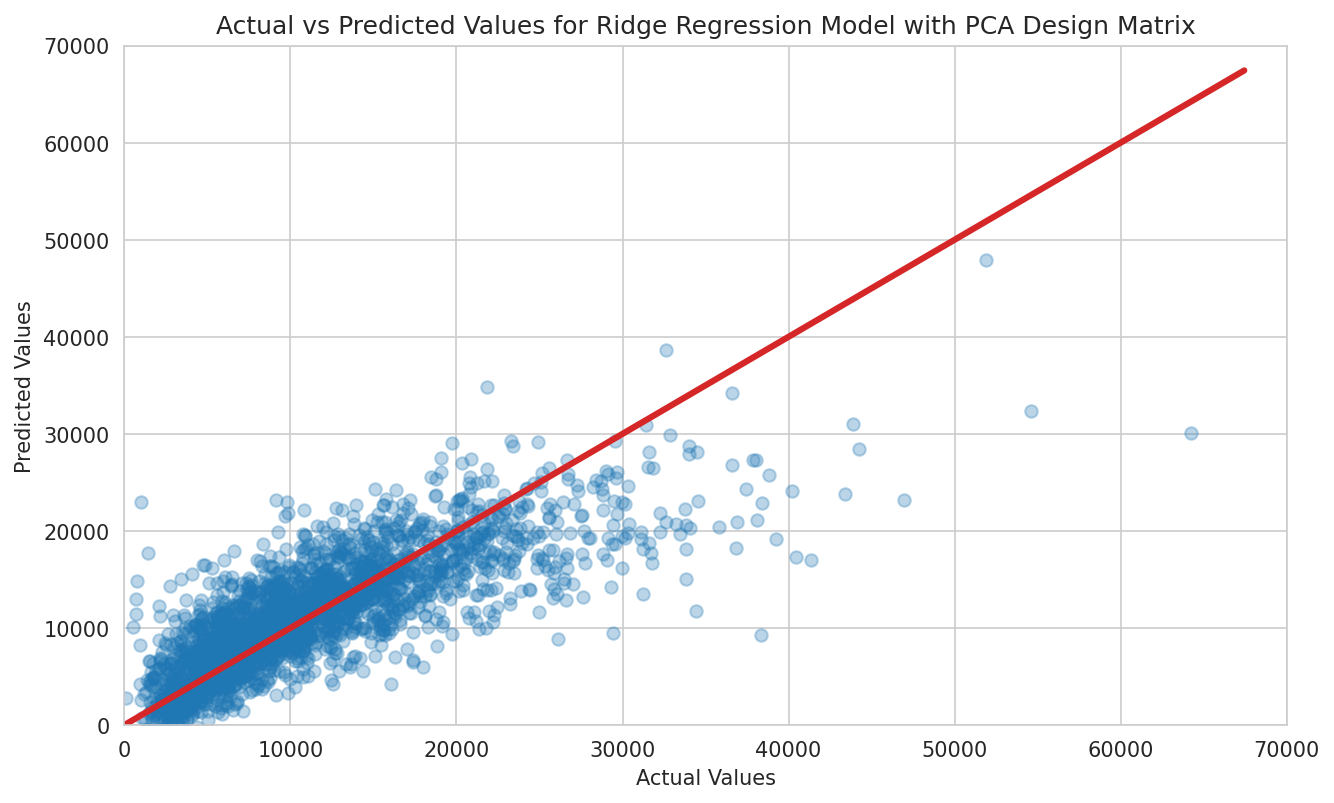

In [79]:
# Plot the data - actual vs predicted
plt.figure(figsize=(10,6), dpi = 150)
plt.scatter(y_pca_test, ridge_pca_pred, alpha = 0.3)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, color='tab:red', lw=3, 
         scalex=False, scaley=False)
plt.xlabel('Actual Values')
plt.xlim(0, 70000)
plt.ylabel('Predicted Values')
plt.ylim(0, 70000)
plt.title('Actual vs Predicted Values for Ridge Regression Model with PCA Design Matrix')
plt.show()

In [80]:
# How is the model performance
mean_squared_error(y_pca_test, ridge_pca_pred, squared = False)

4483.48059510532

So, this model is slightly worse than the lasso (if we are basing it solely off RMSE). Also, since Ridge is a L2 type of penalty, this means that the coefficients won't actually hit 0, but let's see how many have a 'meaningful' effect.

In [81]:
np.set_printoptions(suppress=True)
np.sort(ridge_final.coef_).round(2)

array([-542.77, -439.29, -397.22, -361.3 , -263.22, -262.98, -249.64,
       -239.27, -228.41, -226.76, -218.51, -215.35, -206.17, -202.75,
       -199.92, -188.88, -180.93, -179.45, -175.56, -169.54, -157.85,
       -154.98, -142.73, -142.19, -138.27, -136.08, -129.39, -127.32,
       -120.35, -118.69, -116.89, -114.85, -109.6 , -108.03, -106.13,
       -103.28, -102.03, -101.86, -101.62,  -98.95,  -96.1 ,  -88.64,
        -88.03,  -87.12,  -86.23,  -84.16,  -83.56,  -82.59,  -78.8 ,
        -76.05,  -75.85,  -75.44,  -75.03,  -73.56,  -72.98,  -70.09,
        -68.32,  -68.06,  -67.6 ,  -65.08,  -63.09,  -62.84,  -62.15,
        -60.98,  -60.77,  -60.39,  -60.37,  -60.29,  -56.98,  -56.7 ,
        -55.  ,  -53.58,  -51.  ,  -50.37,  -48.4 ,  -48.28,  -47.95,
        -45.74,  -43.89,  -43.12,  -42.72,  -42.63,  -40.67,  -40.36,
        -38.99,  -38.19,  -37.12,  -36.88,  -36.46,  -35.22,  -34.66,
        -32.31,  -31.15,  -29.08,  -23.42,  -23.31,  -23.3 ,  -20.95,
        -19.88,  -19

### Models without PCA Design Matrix

Let's try to recreate some of the models above using the filtered predictors. Since the Random Forest already didn't perform well, we won't check that. Also, I don't think the Linear Model will perform that well, but we will still check it. 

In [82]:
# Create the new train and test split 
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

#### Linear Regression

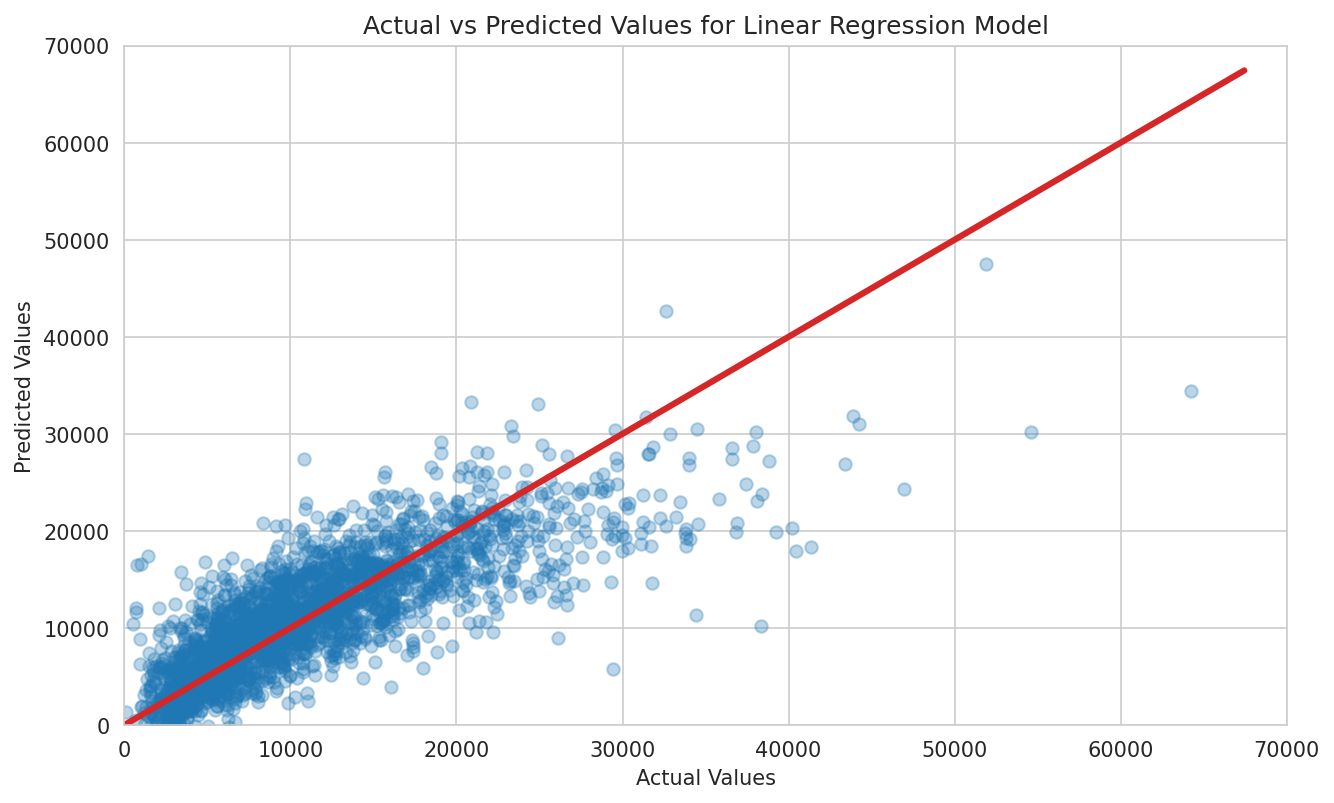

In [83]:
# Create the Linear Regression Instance
regressor = LinearRegression()
# Fit the model
regressor.fit(X_train, y_train)
# Get the predictions
y_pred = regressor.predict(X_test)

# Plot the predictions vs actual
plt.figure(figsize=(10,6), dpi = 150)
plt.scatter(y_test, y_pred, alpha = 0.3)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, color='tab:red', lw=3, 
         scalex=False, scaley=False)
plt.xlabel('Actual Values')
plt.xlim(0, 70000)
plt.ylabel('Predicted Values')
plt.ylim(0, 70000)
plt.title('Actual vs Predicted Values for Linear Regression Model')
plt.show()

In [84]:
# What is the RMSE of the model?
mean_squared_error(y_test, y_pred, squared = False)

4438.339051015145

This is interesting, this model is actually better than all the models using the PCA. This means that even with the large amount of predictors, we aren't overfitting the model which is good. Hopefully this trend continues with the other models. 

#### Support Vector Machine

In [85]:
# Create the parameter grid
svr_param_grid = {'C': [0.1, 1, 3, 10, 30, 100],
                  'epsilon': [0.001, 0.01, 0.1, 1]}
# Create the SVR instance
# We will use Linear SVR since that scales better and the regular SVR will
# take a lot longer. 
svm = LinearSVR(random_state = 0)
# Create the Grid Search
svr_gc = GridSearchCV(estimator = svm, 
                            param_grid = svr_param_grid,
                            cv = 5,
                            verbose = 3,
                            n_jobs = -1,
                            scoring = scorer)

In [86]:
# Tune the parameters
search = svr_gc.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [87]:
pd.DataFrame(search.cv_results_) # The results of the cv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,13.685703,0.302834,0.021156,0.001285,0.1,0.001,"{'C': 0.1, 'epsilon': 0.001}",-6.103374e+07,-5.371141e+07,-6.484157e+07,-3.804003e+07,-4.006193e+07,-5.153774e+07,1.082380e+07,4
1,13.305098,0.137135,0.023253,0.002758,0.1,0.01,"{'C': 0.1, 'epsilon': 0.01}",-6.103357e+07,-5.371130e+07,-6.484144e+07,-3.804002e+07,-4.006193e+07,-5.153765e+07,1.082374e+07,3
2,14.203928,0.675585,0.021423,0.000685,0.1,0.1,"{'C': 0.1, 'epsilon': 0.1}",-6.103191e+07,-5.371028e+07,-6.484014e+07,-3.803994e+07,-4.006187e+07,-5.153683e+07,1.082312e+07,2
3,13.694105,0.110902,0.022123,0.000721,0.1,1,"{'C': 0.1, 'epsilon': 1}",-6.101525e+07,-5.370002e+07,-6.482722e+07,-3.803911e+07,-4.006126e+07,-5.152857e+07,1.081694e+07,1
4,13.498789,0.067870,0.021980,0.000636,1,0.001,"{'C': 1, 'epsilon': 0.001}",-4.568862e+07,-5.579082e+07,-6.087191e+07,-8.952732e+07,-8.073482e+07,-6.652270e+07,1.620099e+07,20
5,13.363921,0.041228,0.021426,0.000628,1,0.01,"{'C': 1, 'epsilon': 0.01}",-4.568854e+07,-5.579073e+07,-6.087178e+07,-8.952719e+07,-8.073470e+07,-6.652259e+07,1.620098e+07,15
6,13.859035,0.071584,0.021963,0.000315,1,0.1,"{'C': 1, 'epsilon': 0.1}",-4.568769e+07,-5.578986e+07,-6.087046e+07,-8.952583e+07,-8.073351e+07,-6.652147e+07,1.620080e+07,10
7,13.344211,0.265300,0.020925,0.000773,1,1,"{'C': 1, 'epsilon': 1}",-4.567929e+07,-5.578115e+07,-6.085726e+07,-8.951227e+07,-8.072161e+07,-6.651031e+07,1.619910e+07,5
8,13.220503,0.034924,0.020965,0.000271,3,0.001,"{'C': 3, 'epsilon': 0.001}",-4.568862e+07,-5.579082e+07,-6.087191e+07,-8.952732e+07,-8.073482e+07,-6.652270e+07,1.620099e+07,20
9,13.038552,0.089026,0.020609,0.001036,3,0.01,"{'C': 3, 'epsilon': 0.01}",-4.568854e+07,-5.579073e+07,-6.087178e+07,-8.952719e+07,-8.073470e+07,-6.652259e+07,1.620098e+07,15


In [88]:
# What are the best parameters? 
search.best_params_

{'C': 0.1, 'epsilon': 1}

In [89]:
# Create a new SVR instance with the tuned parameters
svr_final = LinearSVR(epsilon = 1, 
                      C = 0.1, 
                      random_state = 0)
# Fit the model
svr_final.fit(X_train, y_train)
# Get the predicted values
y_svr_pred = svr_final.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


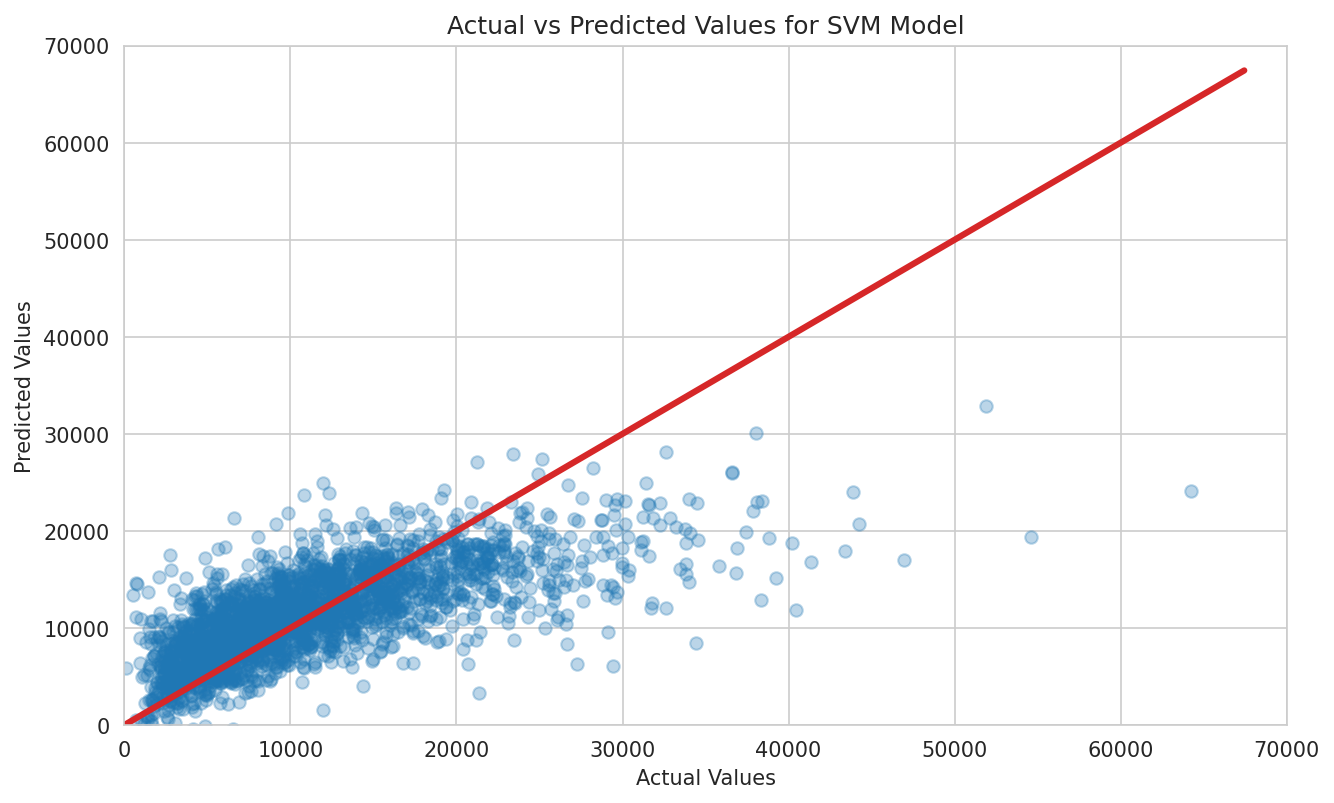

In [90]:
# What does the plot look like
plt.figure(figsize=(10,6), dpi = 150)
plt.scatter(y_test, y_svr_pred, alpha = 0.3)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, color='tab:red', lw=3, 
         scalex=False, scaley=False)
plt.xlabel('Actual Values')
plt.xlim(0, 70000)
plt.ylabel('Predicted Values')
plt.ylim(0, 70000)
plt.title('Actual vs Predicted Values for SVM Model')
plt.show()

In [91]:
# What is the rmse for this model?
mean_squared_error(y_test, y_svr_pred, squared = False)

5205.7840951348335

Unlike the linear regression it looks like the Support Vector Machine might be overfitting with the additional columns, which is why the RMSE is higher than that of the PCA model.

#### KNN

In [92]:
# Create the parameter grid and the knn instance 
knn_parameter_grid = {
    'n_neighbors': [3, 5, 7, 10, 15, 20, 30, 50],
    'leaf_size': [3, 5, 10, 20, 30, 40, 50]
}
knn = KNeighborsRegressor()
# Create the grid search 
knn_gc = GridSearchCV(estimator = knn, 
                            param_grid = knn_parameter_grid,
                            cv = 5,
                            verbose = 3,
                            n_jobs = -1,
                            scoring = scorer)

In [93]:
# Tune the hyperparameters
search_knn = knn_gc.fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


In [94]:
# Results of the CV
pd.DataFrame(search_knn.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_leaf_size,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.140766,0.007809,2.194670,0.091834,3,3,"{'leaf_size': 3, 'n_neighbors': 3}",-4.013564e+07,-5.081358e+07,-4.201450e+07,-4.506346e+07,-4.058948e+07,-4.372333e+07,3.941580e+06,50
1,0.156383,0.032472,2.180181,0.056035,3,5,"{'leaf_size': 3, 'n_neighbors': 5}",-3.778165e+07,-4.603678e+07,-3.734821e+07,-4.224860e+07,-3.804072e+07,-4.029119e+07,3.372439e+06,43
2,0.139934,0.011178,2.154961,0.024893,3,7,"{'leaf_size': 3, 'n_neighbors': 7}",-3.659233e+07,-4.558919e+07,-3.615030e+07,-4.187803e+07,-3.644207e+07,-3.933038e+07,3.784584e+06,36
3,0.133023,0.003102,2.122015,0.018277,3,10,"{'leaf_size': 3, 'n_neighbors': 10}",-3.540793e+07,-4.447938e+07,-3.536255e+07,-4.066946e+07,-3.538381e+07,-3.826062e+07,3.722585e+06,22
4,0.134868,0.008471,2.173855,0.057627,3,15,"{'leaf_size': 3, 'n_neighbors': 15}",-3.542526e+07,-4.474179e+07,-3.532694e+07,-3.995080e+07,-3.479389e+07,-3.804774e+07,3.828830e+06,1
5,0.133324,0.005515,2.143640,0.024575,3,20,"{'leaf_size': 3, 'n_neighbors': 20}",-3.598445e+07,-4.436290e+07,-3.503594e+07,-4.023858e+07,-3.477831e+07,-3.808004e+07,3.706564e+06,8
6,0.130846,0.003322,2.144172,0.019920,3,30,"{'leaf_size': 3, 'n_neighbors': 30}",-3.600342e+07,-4.460984e+07,-3.519122e+07,-4.053777e+07,-3.477309e+07,-3.822307e+07,3.799209e+06,15
7,0.141896,0.005236,2.136719,0.006813,3,50,"{'leaf_size': 3, 'n_neighbors': 50}",-3.648057e+07,-4.529835e+07,-3.551572e+07,-4.132473e+07,-3.493341e+07,-3.871055e+07,3.991982e+06,29
8,0.142221,0.006435,2.055255,0.030087,5,3,"{'leaf_size': 5, 'n_neighbors': 3}",-4.013564e+07,-5.081358e+07,-4.201450e+07,-4.506346e+07,-4.058948e+07,-4.372333e+07,3.941580e+06,50
9,0.143305,0.005521,2.209545,0.035658,5,5,"{'leaf_size': 5, 'n_neighbors': 5}",-3.778165e+07,-4.603678e+07,-3.734821e+07,-4.224860e+07,-3.804072e+07,-4.029119e+07,3.372439e+06,43


In [95]:
# What are the optimal parameter values
search_knn.best_params_

{'leaf_size': 3, 'n_neighbors': 15}

In [96]:
# Fit the final model
knn_final = KNeighborsRegressor(n_neighbors = 15,
                                leaf_size = 3)

knn_final.fit(X_train, y_train)
# Get the perdicted values
knn_pred = knn_final.predict(X_test)

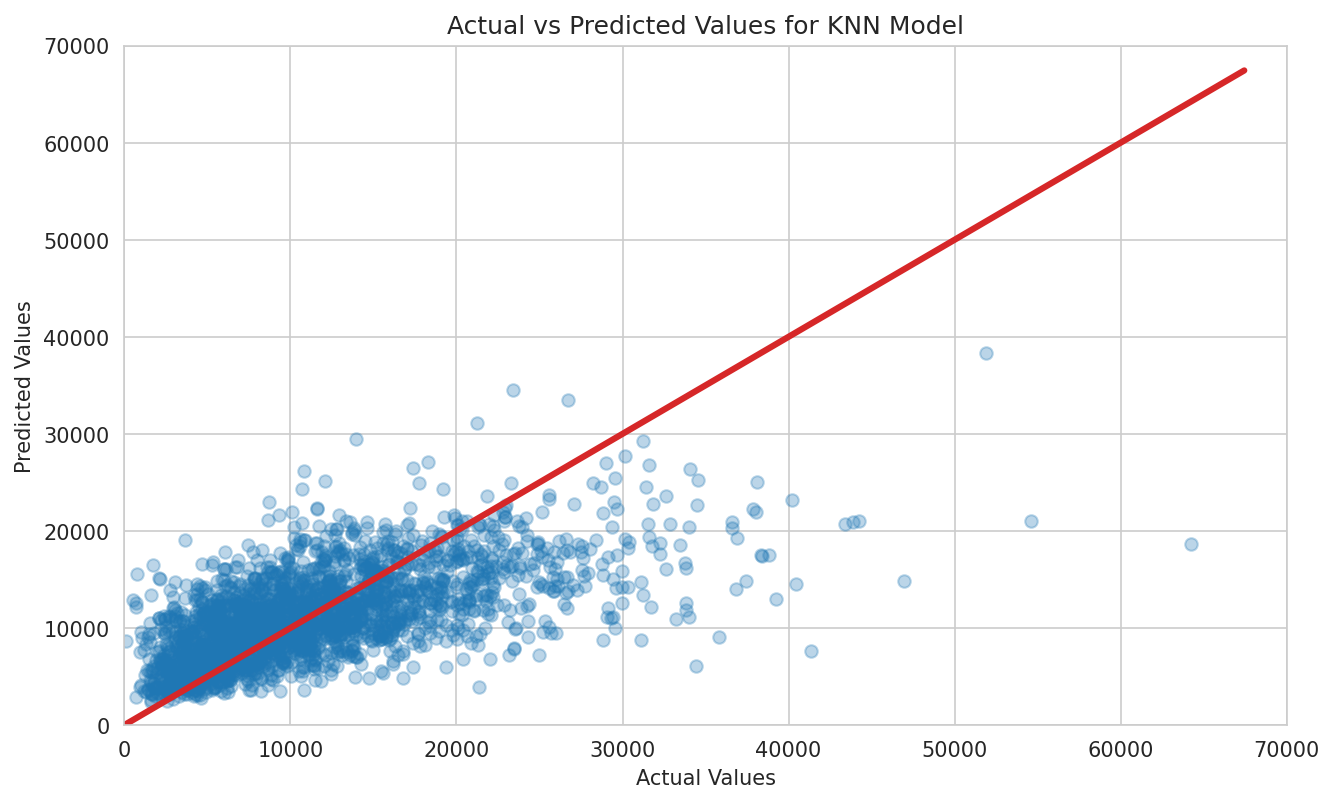

In [97]:
# Plot the values
plt.figure(figsize=(10,6), dpi = 150)
plt.scatter(y_test, knn_pred, alpha = 0.3)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, color='tab:red', lw=3, 
         scalex=False, scaley=False)
plt.xlabel('Actual Values')
plt.xlim(0, 70000)
plt.ylabel('Predicted Values')
plt.ylim(0, 70000)
plt.title('Actual vs Predicted Values for KNN Model')
plt.show()

In [98]:
# Model Performance
mean_squared_error(y_test, knn_pred, squared = False)

5703.482289716883

#### LASSO Regression

In [99]:
# Create the parameter grid and the LASSO instance 
lasso_parameter_grid = {
    'alpha': [0.01, 0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 5, 10]
}
lasso = Lasso(random_state = 0)
# Create the grid search 
lasso_gc = GridSearchCV(estimator = lasso, 
                            param_grid = lasso_parameter_grid,
                            cv = 5,
                            verbose = 3,
                            n_jobs = -1,
                            scoring = scorer)

In [100]:
# Tune the hyperparameters
search_lasso = lasso_gc.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.790e+10, tolerance: 5.761e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [101]:
# Print the results
pd.DataFrame(search_lasso.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,22.687409,2.135996,0.028034,0.001370,0.01,{'alpha': 0.01},-2.101231e+07,-2.905770e+07,-2.127577e+07,-2.445993e+07,-2.118376e+07,-2.339789e+07,3.106709e+06,14
1,20.521572,1.977913,0.027219,0.001079,0.1,{'alpha': 0.1},-2.097467e+07,-2.902972e+07,-2.123064e+07,-2.441740e+07,-2.116134e+07,-2.336275e+07,3.108756e+06,13
2,19.382965,1.873930,0.026199,0.001173,0.3,{'alpha': 0.3},-2.089249e+07,-2.898562e+07,-2.113624e+07,-2.433147e+07,-2.112172e+07,-2.329351e+07,3.118102e+06,11
3,19.923678,2.605973,0.027439,0.001557,0.4,{'alpha': 0.4},-2.085405e+07,-2.897245e+07,-2.109612e+07,-2.429605e+07,-2.111113e+07,-2.326596e+07,3.123906e+06,10
4,19.058098,1.895685,0.027606,0.002455,0.5,{'alpha': 0.5},-2.082604e+07,-2.896111e+07,-2.106187e+07,-2.426182e+07,-2.109863e+07,-2.324190e+07,3.128324e+06,9
5,20.404027,2.741360,0.027705,0.002112,0.6,{'alpha': 0.6},-2.079840e+07,-2.895751e+07,-2.103127e+07,-2.423416e+07,-2.106926e+07,-2.321812e+07,3.137767e+06,8
6,20.720397,2.848591,0.028674,0.001171,0.7,{'alpha': 0.7},-2.077479e+07,-2.893947e+07,-2.099731e+07,-2.421297e+07,-2.104559e+07,-2.319402e+07,3.141414e+06,7
7,19.610110,1.669301,0.027086,0.000983,0.8,{'alpha': 0.8},-2.075233e+07,-2.892881e+07,-2.096327e+07,-2.419105e+07,-2.102345e+07,-2.317178e+07,3.147345e+06,6
8,19.138622,2.349432,0.026608,0.000944,0.9,{'alpha': 0.9},-2.072963e+07,-2.892772e+07,-2.093498e+07,-2.417220e+07,-2.100344e+07,-2.315359e+07,3.155917e+06,5
9,19.204052,2.043665,0.027231,0.001702,1,{'alpha': 1},-2.071329e+07,-2.893239e+07,-2.091122e+07,-2.415469e+07,-2.098418e+07,-2.313915e+07,3.164974e+06,4


In [102]:
# What are the most optimal parameters? 
search_lasso.best_params_

{'alpha': 3}

In [103]:
# Fit the final model
lasso_final = Lasso(alpha = 3,
                    random_state = 0)

lasso_final.fit(X_train, y_train)
# Get the perdicted values
lasso_pred = lasso_final.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.790e+10, tolerance: 5.761e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


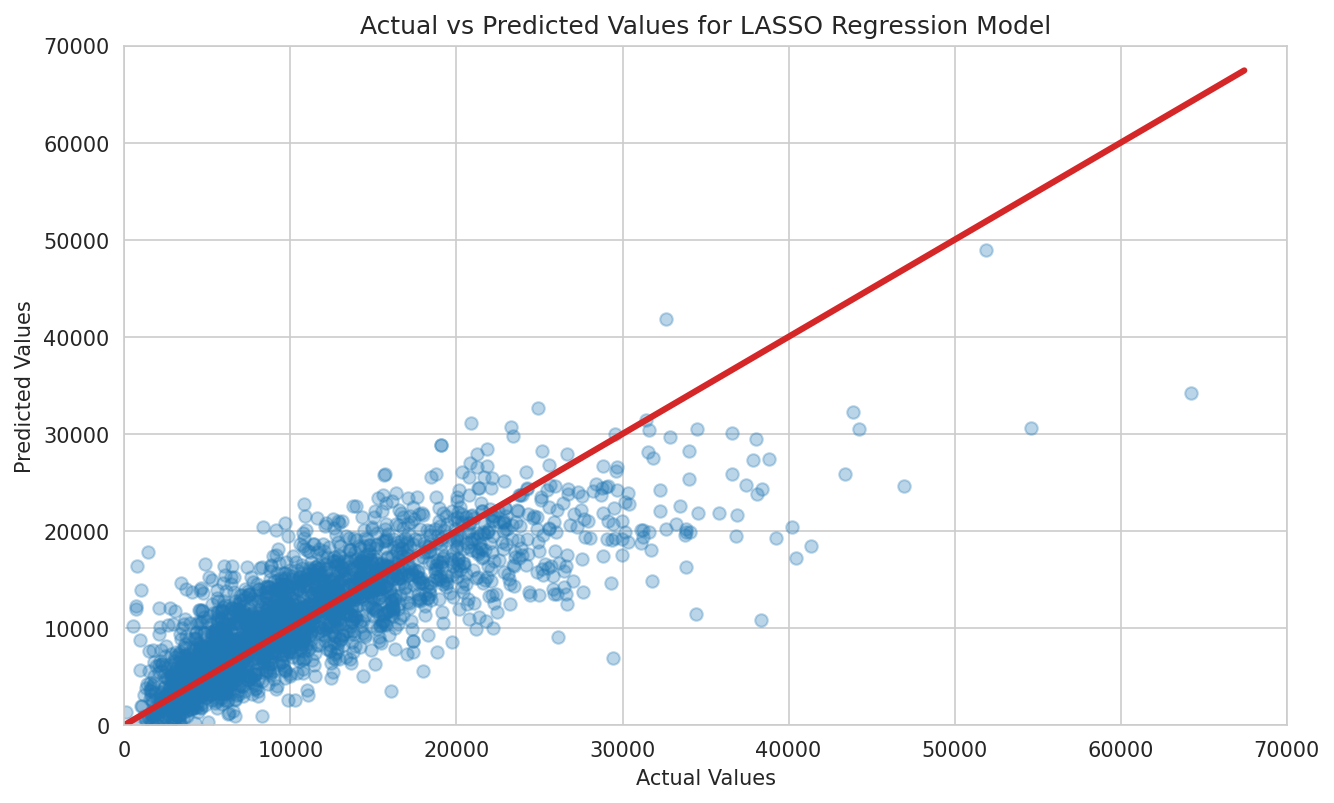

In [104]:
# Plot the data - actual vs predicted
plt.figure(figsize=(10,6), dpi = 150)
plt.scatter(y_test, lasso_pred, alpha = 0.3)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, color='tab:red', lw=3, 
         scalex=False, scaley=False)
plt.xlabel('Actual Values')
plt.xlim(0, 70000)
plt.ylabel('Predicted Values')
plt.ylim(0, 70000)
plt.title('Actual vs Predicted Values for LASSO Regression Model')
plt.show()

In [105]:
# How is the model performance
mean_squared_error(y_test, lasso_pred, squared = False)

4377.482514813419

In [106]:
sum(lasso_final.coef_ != 0)

518

We are removing a lot of columns here - out of the 951 predictors we are only using 518.

#### Ridge Regression

In [107]:
# Create the parameter grid and the Ridge instance 
ridge_parameter_grid = {
    'alpha': [30, 40, 50, 60, 70, 80, 90, 100, 300, 500, 800, 900, 
              1000, 3000, 5000]
}
ridge = Ridge(random_state = 0)
# Create the grid search 
ridge_gc = GridSearchCV(estimator = ridge, 
                            param_grid = ridge_parameter_grid,
                            cv = 5,
                            verbose = 3,
                            n_jobs = -1,
                            scoring = scorer)

In [108]:
# Tune the hyperparameters
search_ridge = ridge_gc.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [109]:
# Print the results
pd.DataFrame(search_ridge.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.833384,0.058912,0.028210,0.004188,30,{'alpha': 30},-2.140637e+07,-2.919652e+07,-2.114510e+07,-2.434362e+07,-2.123283e+07,-2.346489e+07,3.105632e+06,8
1,0.786477,0.010228,0.027241,0.001198,40,{'alpha': 40},-2.138861e+07,-2.923454e+07,-2.113029e+07,-2.430583e+07,-2.120598e+07,-2.345305e+07,3.125997e+06,6
2,0.771354,0.022005,0.032104,0.006821,50,{'alpha': 50},-2.137645e+07,-2.926856e+07,-2.112266e+07,-2.427756e+07,-2.118612e+07,-2.344627e+07,3.142665e+06,4
3,0.749006,0.011686,0.026471,0.005633,60,{'alpha': 60},-2.136913e+07,-2.930015e+07,-2.112001e+07,-2.425590e+07,-2.117125e+07,-2.344329e+07,3.156743e+06,2
4,0.773314,0.007536,0.025848,0.001158,70,{'alpha': 70},-2.136575e+07,-2.933007e+07,-2.112106e+07,-2.423919e+07,-2.116015e+07,-2.344324e+07,3.168890e+06,1
5,0.778999,0.022343,0.028466,0.005471,80,{'alpha': 80},-2.136553e+07,-2.935873e+07,-2.112495e+07,-2.422635e+07,-2.115200e+07,-2.344551e+07,3.179542e+06,3
6,0.717069,0.018704,0.024380,0.002155,90,{'alpha': 90},-2.136782e+07,-2.938638e+07,-2.113105e+07,-2.421662e+07,-2.114620e+07,-2.344961e+07,3.189006e+06,5
7,0.748119,0.028897,0.025766,0.001920,100,{'alpha': 100},-2.137212e+07,-2.941317e+07,-2.113891e+07,-2.420945e+07,-2.114229e+07,-2.345519e+07,3.197508e+06,7
8,0.733388,0.013735,0.023919,0.002557,300,{'alpha': 300},-2.158557e+07,-2.984897e+07,-2.140400e+07,-2.428406e+07,-2.121006e+07,-2.366653e+07,3.288998e+06,9
9,0.794980,0.027723,0.028113,0.002230,500,{'alpha': 500},-2.181209e+07,-3.018173e+07,-2.166780e+07,-2.446187e+07,-2.133370e+07,-2.389144e+07,3.337769e+06,10


In [110]:
# What are the most optimal parameters? 
search_ridge.best_params_

{'alpha': 70}

In [111]:
# Fit the final model
ridge_final = Ridge(alpha = 70,
                    random_state = 0)

ridge_final.fit(X_train, y_train)
# Get the perdicted values
ridge_pred = ridge_final.predict(X_test)

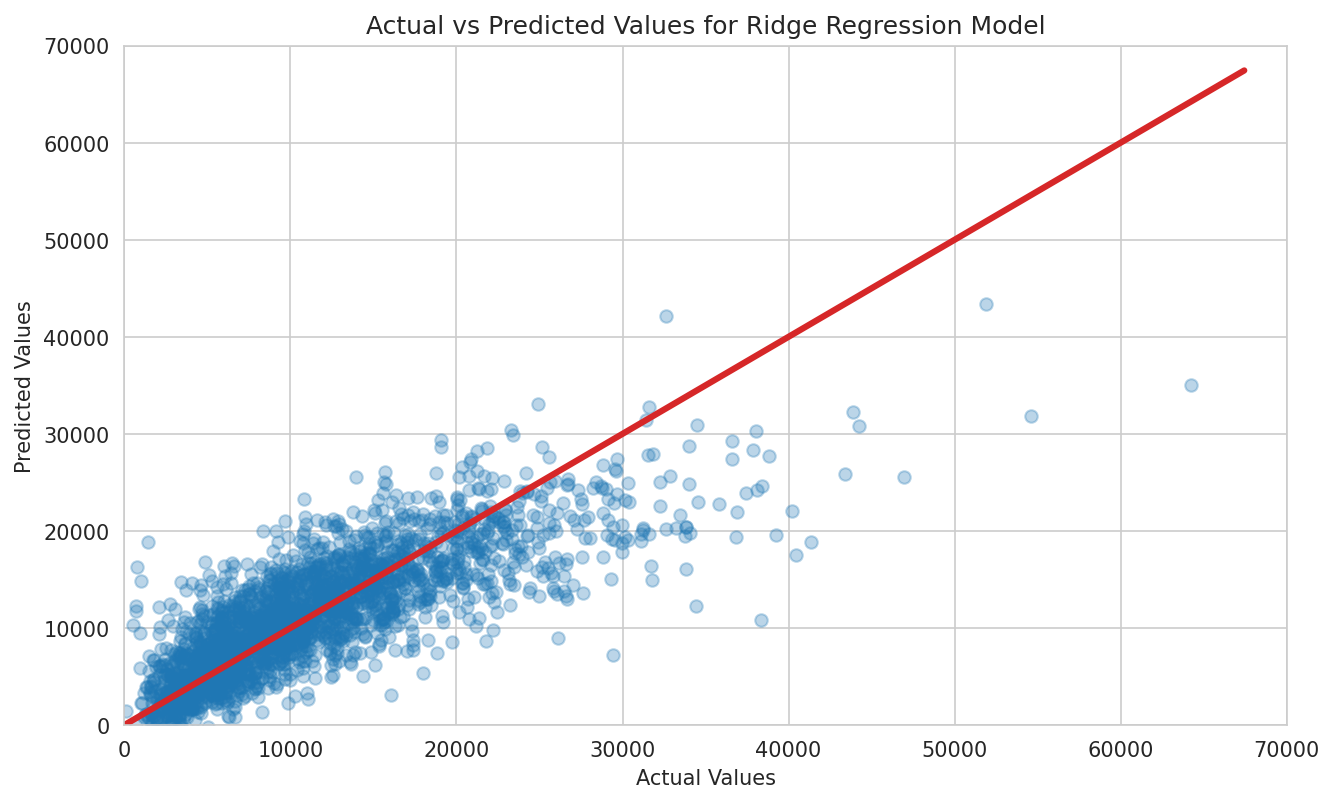

In [112]:
# Plot the data - actual vs predicted
plt.figure(figsize=(10,6), dpi = 150)
plt.scatter(y_test, ridge_pred, alpha = 0.3)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, color='tab:red', lw=3, 
         scalex=False, scaley=False)
plt.xlabel('Actual Values')
plt.xlim(0, 70000)
plt.ylabel('Predicted Values')
plt.ylim(0, 70000)
plt.title('Actual vs Predicted Values for Ridge Regression Model')
plt.show()

In [113]:
# How is the model performance
mean_squared_error(y_test, ridge_pred, squared = False)

4404.272865319921

## Final Thoughts

### Model Performance

Let's summarize the models that we used and their performances. The different algorithms that we used were Linear Regression, Support Vector Machine, Random Forest, K Nearest Neighbor, LASSO Regression & Ridge Regression. For all of these (except for the Random Forest) we used two different design matricies. The first was the filtered version of the original dataset. During the feature engineering phase, we filtered out columns that would probably not help in predicting the energy output. Then, once we had the filtered dataset, we left the continuous as it is and performed One Hot Encoding for the categorical data. The second design matric was the one where we performed Principal Component Analysis to further perform dimensionality reduction. Below is a table that summarizes the results;   

$$
\begin{aligned}
& \text {Table 1 Model Performance Summary }\\
&\begin{array}{lcc}
\hline
\text { Model } & \text { RMSE } & \text { RMSE % Decrease from Null Model }\\
\hline 
\text{Null Model} & 7314.7 & \text{NA} \\
\text{Linear Regression with PCA} & 4512.1 & 38.3\% \\
\text{Linear Regression}& 4438.3 & 39.3\% \\
\text{SVM with PCA} & 4541.2 & 37.9\% \\
\text{SVM} & 5205.8 & 28.8\% \\
\text{RF with PCA} & 5413.2 & 26.0\% \\
\text{KNN with PCA} & 5048.1 & 31.0\% \\
\text{KNN} & 5703.5 & 22.0\% \\
\text{LASSO with PCA} & 4470.2 & 38.9\% \\
\text{LASSO} & 4377.5 & 40.2\% \\
\text{Ridge with PCA} & 4483.5 & 38.7\% \\
\text{Ridge} & 4404.3 & 39.8\% \\
\hline
\end{array}
\end{aligned}
$$

Using the table above, we see that the best model we had was the LASSO when not using the PCA predictors. However, the Linear Regression and Ridge Regression models perform almost as well (along with the SVM with PCA model).  
* A pattern that we see for all the models is, when the actual KWN is on the higher end, our models generally underestimate the electricity. This might be something we want to take a look at when considering how to improve our model performance.  
* It seems like the best model we have is the LASSO which sets some of the  coefficients of the $\beta$ matrix to 0. For the best model we have, we see that out of the possible 951 predictors, it is only using 518. So, it might be interesting to re-run the SVM and KNN with those 518 predictors and re-run the SVM, KNN and RF with the 221 PCA predictors. We aren't assured we will get a better model but it may be interesting to examine. 

### Appendix  

List of articles used (some of them are pdfs and will be downloaded once you click on them).  

https://www.nber.org/system/files/working_papers/w26531/w26531.pdf

https://www.mdpi.com/1996-1073/14/22/7810/pdf

https://www.sciencedirect.com/science/article/pii/S235271022101264X